In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/chandniagarwal/Gan_Classifier.git

Cloning into 'Gan_Classifier'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 70 (delta 19), reused 65 (delta 14), pack-reused 0
Receiving objects: 100% (70/70), 3.85 MiB | 35.87 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [3]:
!mkdir training
!cp -r /content/drive/MyDrive/researchwork_15.9.203/training_dataset/recon /content/training/recon
!cp -r /content/drive/MyDrive/researchwork_15.9.203/training_dataset/celebagt /content/training/ground
!cp -r /content/drive/MyDrive/researchwork_15.9.203/testing /content/testing

In [4]:
import sys
sys.path.append('/content/Gan_Classifier/src')
import glob
import os
import numpy as np
import cv2
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import *
from keras import optimizers


from keras.models import Sequential
from keras.layers import Input, Dense, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

import time
import random
import seaborn as sns
from DatasetCreation import DatasetCreation
from Model import Model
from ElmModel import elm
from numba import cuda

In [5]:
tf.random.set_seed(
    42
)
gpus = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(gpus[0], True)
list_images=[]
labels=[]

In [6]:
# Testing Data Location
test_gt = "/content/drive/MyDrive/researchwork_15.9.203/testing/gt"
test_gen = "/content/drive/MyDrive/researchwork_15.9.203/testing/gen"
test_ec = "/content/drive/MyDrive/researchwork_15.9.203/testing/ec"
test_vqvae = "/content/drive/MyDrive/researchwork_15.9.203/testing/vqvae"
test_mask = "/content/drive/MyDrive/imageclassificationmodel/dataset/mask2000"
test_unmask = "/content/drive/MyDrive/imageclassificationmodel/dataset/gt2000"


In [7]:
# test_gt = '/content/drive/MyDrive/imageclassificationmodel/dataset/pixgan20epochs/e3'
# test_vqvae='/content/drive/MyDrive/imageclassificationmodel/dataset/pixgan20epochs/g3'

In [8]:
# Training Data Location
train_gt='/content/training/ground'
train_recon='/content/training/recon'

In [9]:
# training Data
image_loc_ground = glob.glob(train_gt+"/*.jpg")
labels = len(image_loc_ground) * ["ground"]
image_loc_recon = glob.glob(train_recon+"/*.jpg")

labels += len(image_loc_recon) * ["recon"]
image_loc = image_loc_ground + image_loc_recon

training_dataset = DatasetCreation(image_loc, labels, "one_hot")
# for 152 layer
training_dataset_152_layer = DatasetCreation(
    image_loc, labels, "one_hot", tf.keras.applications.resnet50.preprocess_input
)
print(training_dataset.images.shape)
print(training_dataset.labels.shape)

_________Loading Images__________


100%|██████████| 7178/7178 [00:24<00:00, 294.56it/s]


_________Loading Images__________


100%|██████████| 7178/7178 [00:13<00:00, 540.43it/s]


(7178, 224, 224, 3)
(7178, 2)


## load model

In [10]:
def load_model(model_function, layers_to_train):
  start = time.time()
  # load resnet model
  base_model = model_function(
      input_shape=(224,224,3),
      include_top=False,
      weights='imagenet'
  )

  for layer in base_model.layers:
      layer.trainable = False

  for layer in layers_to_train:
    base_model.get_layer(layer).trainable = True


  # Create your binary classification layers on top of the base model
  x = base_model.output
  x = tf.keras.layers.GlobalAveragePooling2D()(x)  # Add a global average pooling layer
  x = tf.keras.layers.Dense(1000, activation='relu')(x) # intermediate hidden layer
  x = tf.keras.layers.Dropout(0.2)(x)
  predictions = tf.keras.layers.Dense(2, activation='softmax')(x)  # Binary classification output layer

  # Combine the base model and your custom layers into a new model
  model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

  print('Running time: %.4f seconds' % (time.time()-start))
  return model

In [11]:
model_resnet_152_full = load_model(tf.keras.applications.ResNet152, ["conv5_block3_3_bn", "conv5_block3_3_conv"])
model_resnet_101_full = load_model(tf.keras.applications.ResNet101, ["conv5_block3_3_bn", "conv5_block3_3_conv"])
model_resnet_50_full = load_model(tf.keras.applications.ResNet50, ["conv5_block3_3_bn", "conv5_block3_3_conv"])
model_vgg_16_full = load_model(tf.keras.applications.vgg16.VGG16, ["block5_conv3"])
model_vgg_19_full = load_model(tf.keras.applications.vgg19.VGG19, ["block5_conv3"])

model_resnet_152_freeze = load_model(tf.keras.applications.ResNet152, [])
model_resnet_101_freeze = load_model(tf.keras.applications.ResNet101, [])
model_resnet_50_freeze = load_model(tf.keras.applications.ResNet50, [])
model_vgg_16_freeze = load_model(tf.keras.applications.vgg16.VGG16, [])
model_vgg_19_freeze = load_model(tf.keras.applications.vgg19.VGG19, [])

234698864/234698864 [==============================] - 12s 0us/step
Running time: 19.8606 seconds
171446536/171446536 [==============================] - 9s 0us/step
Running time: 12.4438 seconds
94765736/94765736 [==============================] - 5s 0us/step
Running time: 6.9833 seconds
58889256/58889256 [==============================] - 4s 0us/step
Running time: 4.2235 seconds
80134624/80134624 [==============================] - 4s 0us/step
Running time: 4.5574 seconds
Running time: 4.8202 seconds
Running time: 3.1133 seconds
Running time: 1.6092 seconds
Running time: 0.3348 seconds
Running time: 0.4190 seconds


In [12]:
model_softmax = {
    "Resnet_152_full": model_resnet_152_full,
    "Resnet_101_full": model_resnet_101_full,
    "Resnet_50_full": model_resnet_50_full,
    "Resnet_152_freeze": model_resnet_152_freeze,
    "Resnet_101_freeze": model_resnet_101_freeze,
    "Resnet_50_freeze": model_resnet_50_freeze,
    "VGG_16_full": model_vgg_16_full,
    "VGG_19_full": model_vgg_19_full,
    "VGG_16_freeze": model_vgg_16_freeze,
    "VGG_19_freeze": model_vgg_19_freeze,
}
model_data = {
    "Resnet_152_full": training_dataset_152_layer,
    "Resnet_101_full": training_dataset,
    "Resnet_50_full": training_dataset,
    "Resnet_152_freeze": training_dataset_152_layer,
    "Resnet_101_freeze": training_dataset,
    "Resnet_50_freeze": training_dataset,
    "VGG_16_full": training_dataset,
    "VGG_19_full": training_dataset,
    "VGG_16_freeze": training_dataset,
    "VGG_19_freeze": training_dataset,
}

## Training

__________ Resnet_152_full __________________________________________________
Epoch 1/25
90/90 [==============================] - 34s 157ms/step - loss: 0.8296 - accuracy: 0.7114 - val_loss: 0.4296 - val_accuracy: 0.7709 - lr: 0.0010
Epoch 2/25
90/90 [==============================] - 9s 97ms/step - loss: 0.3791 - accuracy: 0.8318 - val_loss: 0.4276 - val_accuracy: 0.7827 - lr: 0.0010
Epoch 3/25
90/90 [==============================] - 7s 82ms/step - loss: 0.2993 - accuracy: 0.8737 - val_loss: 0.5891 - val_accuracy: 0.7194 - lr: 0.0010
Epoch 4/25
90/90 [==============================] - 7s 81ms/step - loss: 0.2470 - accuracy: 0.8981 - val_loss: 0.5766 - val_accuracy: 0.7375 - lr: 0.0010
Epoch 5/25
90/90 [==============================] - 7s 81ms/step - loss: 0.1857 - accuracy: 0.9241 - val_loss: 0.5625 - val_accuracy: 0.7960 - lr: 0.0010
Epoch 6/25
90/90 [==============================] - 9s 97ms/step - loss: 0.1758 - accuracy: 0.9288 - val_loss: 0.3236 - val_accuracy: 0.8517 - lr: 0.0

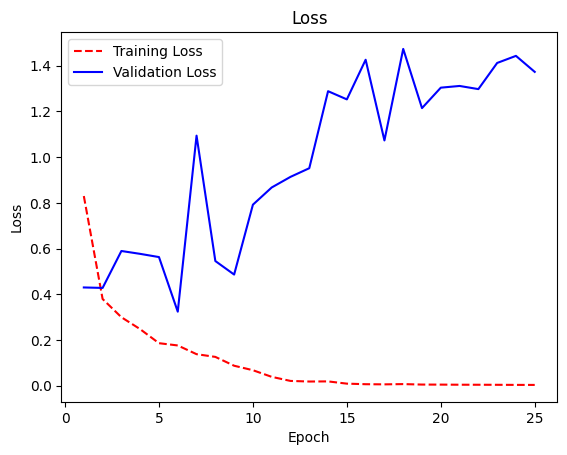

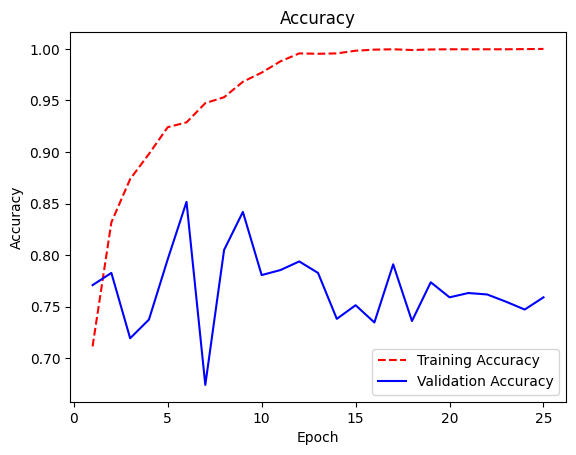

Epoch: 6
loss:0.18
accuracy:0.93
val_loss:0.32
val_accuracy:0.85
lr:0.0
__________ Resnet_101_full __________________________________________________
Epoch 1/25
90/90 [==============================] - 17s 110ms/step - loss: 0.7433 - accuracy: 0.5895 - val_loss: 1.2580 - val_accuracy: 6.9638e-04 - lr: 0.0010
Epoch 2/25
90/90 [==============================] - 6s 64ms/step - loss: 0.6517 - accuracy: 0.6226 - val_loss: 1.2798 - val_accuracy: 0.0014 - lr: 0.0010
Epoch 3/25
90/90 [==============================] - 7s 75ms/step - loss: 0.6337 - accuracy: 0.6405 - val_loss: 0.9364 - val_accuracy: 0.2145 - lr: 0.0010
Epoch 4/25
90/90 [==============================] - 6s 64ms/step - loss: 0.6251 - accuracy: 0.6480 - val_loss: 1.1317 - val_accuracy: 0.1386 - lr: 0.0010
Epoch 5/25
90/90 [==============================] - 6s 64ms/step - loss: 0.6125 - accuracy: 0.6703 - val_loss: 1.0118 - val_accuracy: 0.2493 - lr: 0.0010
Epoch 6/25
90/90 [==============================] - 7s 76ms/step - loss: 0

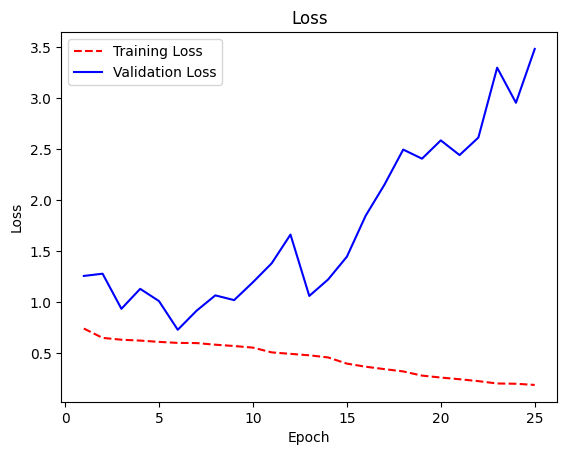

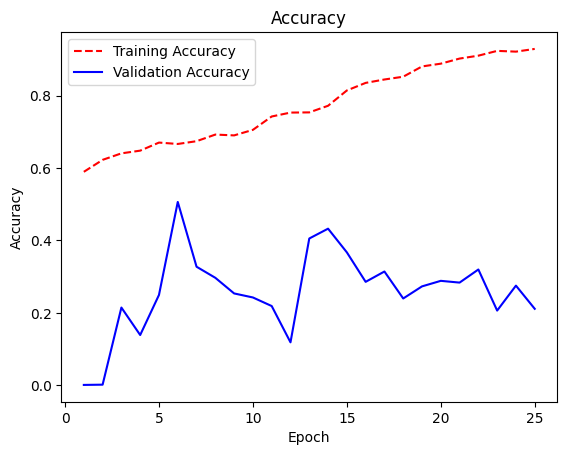

Epoch: 6
loss:0.6
accuracy:0.67
val_loss:0.73
val_accuracy:0.51
lr:0.0
__________ Resnet_50_full __________________________________________________
Epoch 1/25
90/90 [==============================] - 12s 80ms/step - loss: 0.7853 - accuracy: 0.6045 - val_loss: 0.8464 - val_accuracy: 0.3377 - lr: 0.0010
Epoch 2/25
90/90 [==============================] - 4s 46ms/step - loss: 0.6454 - accuracy: 0.6350 - val_loss: 1.1760 - val_accuracy: 0.0313 - lr: 0.0010
Epoch 3/25
90/90 [==============================] - 5s 52ms/step - loss: 0.6280 - accuracy: 0.6486 - val_loss: 0.6100 - val_accuracy: 0.6887 - lr: 0.0010
Epoch 4/25
90/90 [==============================] - 4s 46ms/step - loss: 0.6157 - accuracy: 0.6590 - val_loss: 1.1272 - val_accuracy: 0.1184 - lr: 0.0010
Epoch 5/25
90/90 [==============================] - 4s 46ms/step - loss: 0.6087 - accuracy: 0.6648 - val_loss: 0.8459 - val_accuracy: 0.4276 - lr: 0.0010
Epoch 6/25
90/90 [==============================] - 4s 46ms/step - loss: 0.5979 -

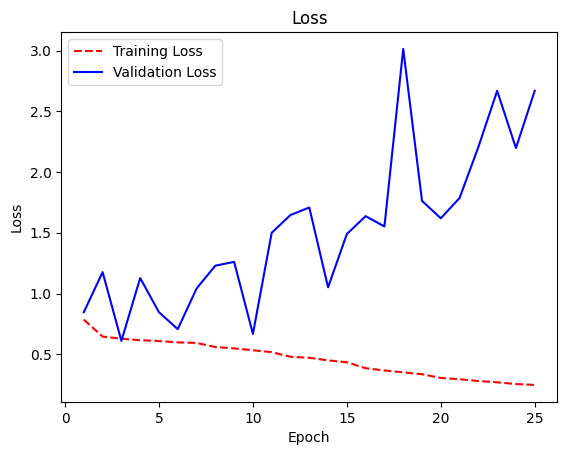

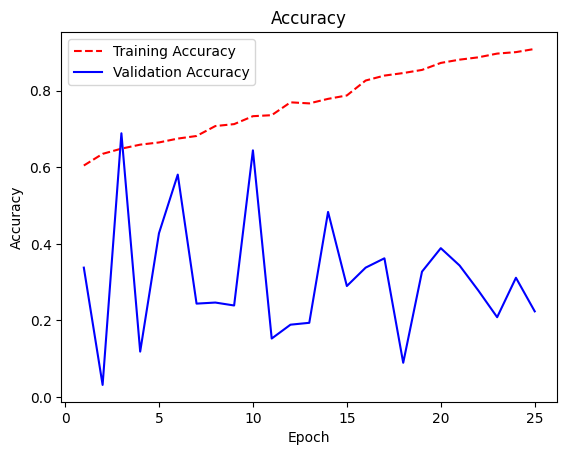

Epoch: 3
loss:0.63
accuracy:0.65
val_loss:0.61
val_accuracy:0.69
lr:0.0
__________ Resnet_152_freeze __________________________________________________
Epoch 1/25
90/90 [==============================] - 21s 137ms/step - loss: 0.7687 - accuracy: 0.7059 - val_loss: 0.9812 - val_accuracy: 0.4603 - lr: 0.0010
Epoch 2/25
90/90 [==============================] - 8s 92ms/step - loss: 0.4248 - accuracy: 0.8128 - val_loss: 0.9159 - val_accuracy: 0.5341 - lr: 0.0010
Epoch 3/25
90/90 [==============================] - 8s 93ms/step - loss: 0.3809 - accuracy: 0.8339 - val_loss: 0.5502 - val_accuracy: 0.7201 - lr: 0.0010
Epoch 4/25
90/90 [==============================] - 7s 77ms/step - loss: 0.3474 - accuracy: 0.8494 - val_loss: 0.6535 - val_accuracy: 0.6790 - lr: 0.0010
Epoch 5/25
90/90 [==============================] - 7s 77ms/step - loss: 0.3028 - accuracy: 0.8680 - val_loss: 0.7241 - val_accuracy: 0.6657 - lr: 0.0010
Epoch 6/25
90/90 [==============================] - 8s 92ms/step - loss: 0.2

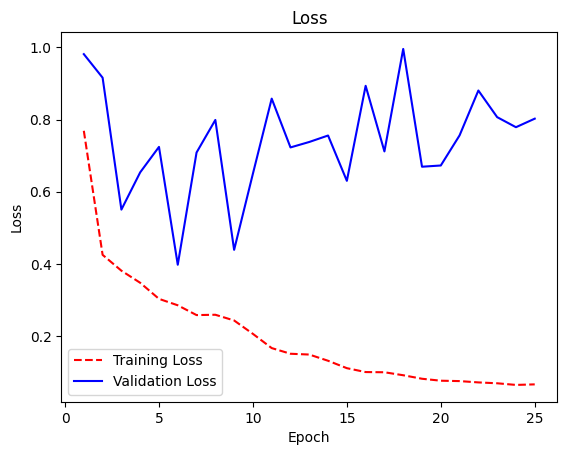

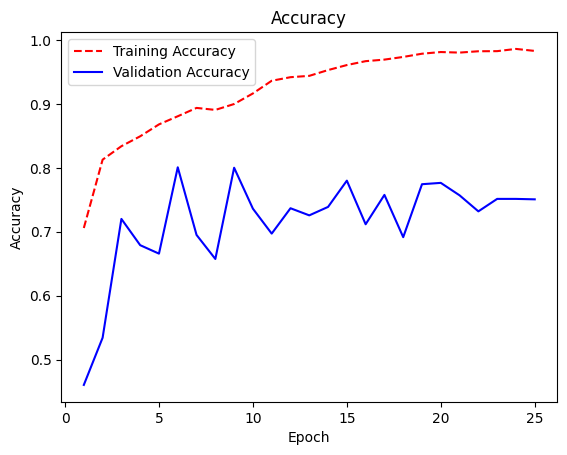

Epoch: 6
loss:0.28
accuracy:0.88
val_loss:0.4
val_accuracy:0.8
lr:0.0
__________ Resnet_101_freeze __________________________________________________
Epoch 1/25
90/90 [==============================] - 16s 102ms/step - loss: 0.7821 - accuracy: 0.5825 - val_loss: 1.1776 - val_accuracy: 0.0035 - lr: 0.0010
Epoch 2/25
90/90 [==============================] - 6s 69ms/step - loss: 0.6572 - accuracy: 0.6228 - val_loss: 0.8385 - val_accuracy: 0.2472 - lr: 0.0010
Epoch 3/25
90/90 [==============================] - 6s 70ms/step - loss: 0.6420 - accuracy: 0.6273 - val_loss: 0.8093 - val_accuracy: 0.3844 - lr: 0.0010
Epoch 4/25
90/90 [==============================] - 5s 59ms/step - loss: 0.6410 - accuracy: 0.6277 - val_loss: 1.0968 - val_accuracy: 0.0557 - lr: 0.0010
Epoch 5/25
90/90 [==============================] - 5s 59ms/step - loss: 0.6330 - accuracy: 0.6400 - val_loss: 0.8487 - val_accuracy: 0.3106 - lr: 0.0010
Epoch 6/25
90/90 [==============================] - 6s 70ms/step - loss: 0.628

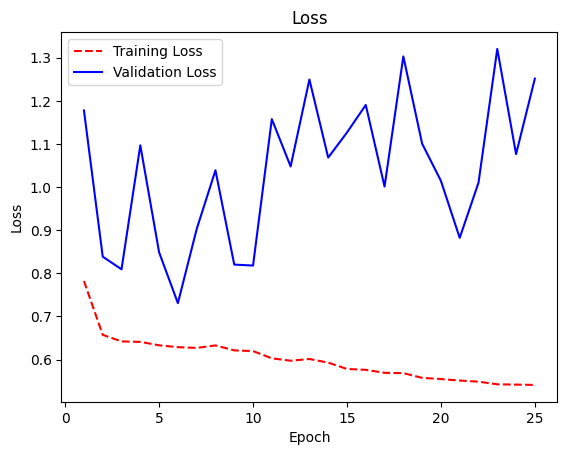

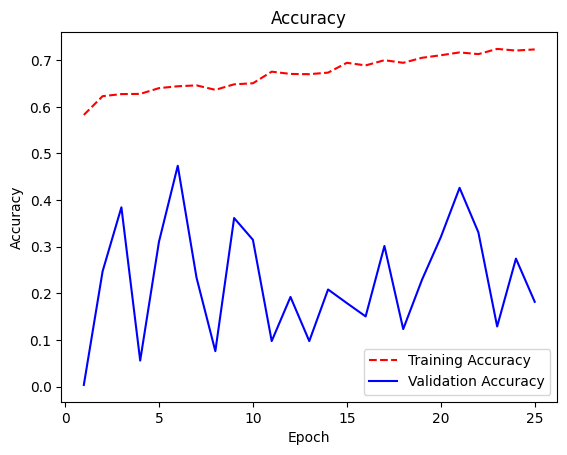

Epoch: 6
loss:0.63
accuracy:0.64
val_loss:0.73
val_accuracy:0.47
lr:0.0
__________ Resnet_50_freeze __________________________________________________
Epoch 1/25
90/90 [==============================] - 10s 73ms/step - loss: 0.7999 - accuracy: 0.5913 - val_loss: 1.1194 - val_accuracy: 0.0160 - lr: 0.0010
Epoch 2/25
90/90 [==============================] - 5s 50ms/step - loss: 0.6546 - accuracy: 0.6209 - val_loss: 0.7903 - val_accuracy: 0.3531 - lr: 0.0010
Epoch 3/25
90/90 [==============================] - 4s 44ms/step - loss: 0.6370 - accuracy: 0.6346 - val_loss: 0.8365 - val_accuracy: 0.3398 - lr: 0.0010
Epoch 4/25
90/90 [==============================] - 4s 44ms/step - loss: 0.6339 - accuracy: 0.6392 - val_loss: 1.0265 - val_accuracy: 0.1539 - lr: 0.0010
Epoch 5/25
90/90 [==============================] - 4s 50ms/step - loss: 0.6280 - accuracy: 0.6496 - val_loss: 0.7565 - val_accuracy: 0.4561 - lr: 0.0010
Epoch 6/25
90/90 [==============================] - 4s 50ms/step - loss: 0.626

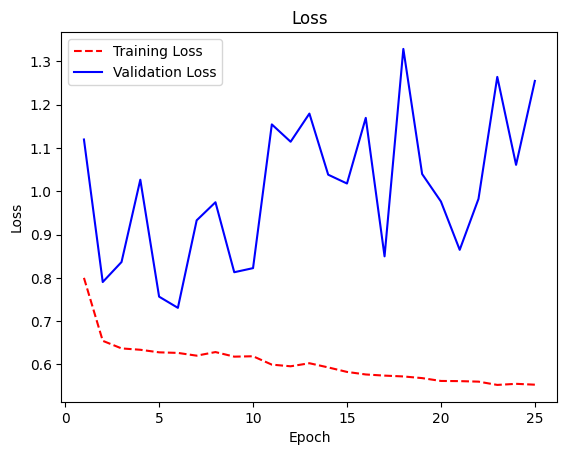

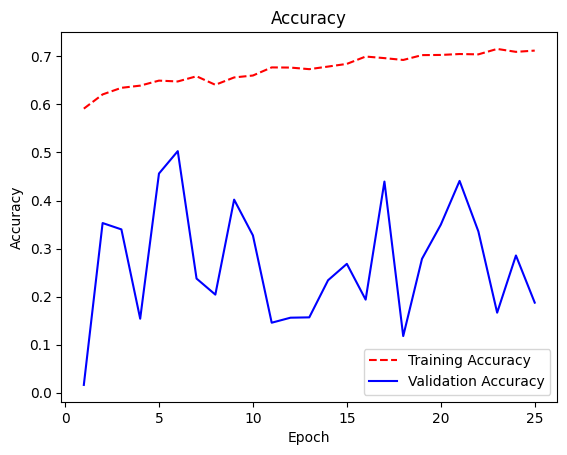

Epoch: 6
loss:0.63
accuracy:0.65
val_loss:0.73
val_accuracy:0.5
lr:0.0
__________ VGG_16_full __________________________________________________
Epoch 1/25
90/90 [==============================] - 11s 82ms/step - loss: 0.5726 - accuracy: 0.7029 - val_loss: 0.7708 - val_accuracy: 0.5933 - lr: 0.0010
Epoch 2/25
90/90 [==============================] - 4s 48ms/step - loss: 0.3162 - accuracy: 0.8676 - val_loss: 0.4505 - val_accuracy: 0.7751 - lr: 0.0010
Epoch 3/25
90/90 [==============================] - 4s 48ms/step - loss: 0.2344 - accuracy: 0.9013 - val_loss: 0.3171 - val_accuracy: 0.8649 - lr: 0.0010
Epoch 4/25
90/90 [==============================] - 4s 47ms/step - loss: 0.1991 - accuracy: 0.9220 - val_loss: 0.4273 - val_accuracy: 0.8071 - lr: 0.0010
Epoch 5/25
90/90 [==============================] - 4s 49ms/step - loss: 0.1650 - accuracy: 0.9352 - val_loss: 0.1481 - val_accuracy: 0.9464 - lr: 0.0010
Epoch 6/25
90/90 [==============================] - 4s 49ms/step - loss: 0.1507 - ac

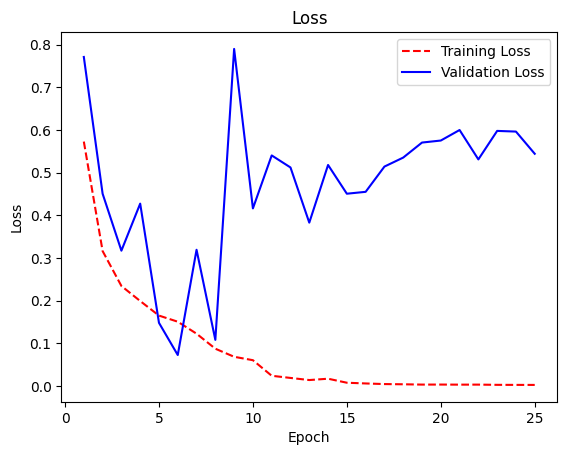

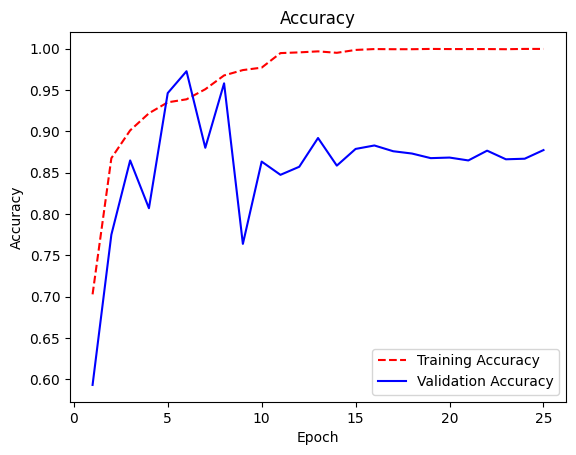

Epoch: 6
loss:0.15
accuracy:0.94
val_loss:0.07
val_accuracy:0.97
lr:0.0
__________ VGG_19_full __________________________________________________
Epoch 1/25
90/90 [==============================] - 8s 76ms/step - loss: 0.4968 - accuracy: 0.7543 - val_loss: 0.3605 - val_accuracy: 0.8795 - lr: 0.0010
Epoch 2/25
90/90 [==============================] - 5s 56ms/step - loss: 0.2824 - accuracy: 0.8856 - val_loss: 0.3200 - val_accuracy: 0.8705 - lr: 0.0010
Epoch 3/25
90/90 [==============================] - 5s 53ms/step - loss: 0.1991 - accuracy: 0.9218 - val_loss: 0.3350 - val_accuracy: 0.8670 - lr: 0.0010
Epoch 4/25
90/90 [==============================] - 5s 56ms/step - loss: 0.1672 - accuracy: 0.9342 - val_loss: 0.2666 - val_accuracy: 0.8955 - lr: 0.0010
Epoch 5/25
90/90 [==============================] - 5s 53ms/step - loss: 0.1565 - accuracy: 0.9404 - val_loss: 0.3575 - val_accuracy: 0.8586 - lr: 0.0010
Epoch 6/25
90/90 [==============================] - 5s 56ms/step - loss: 0.1630 - ac

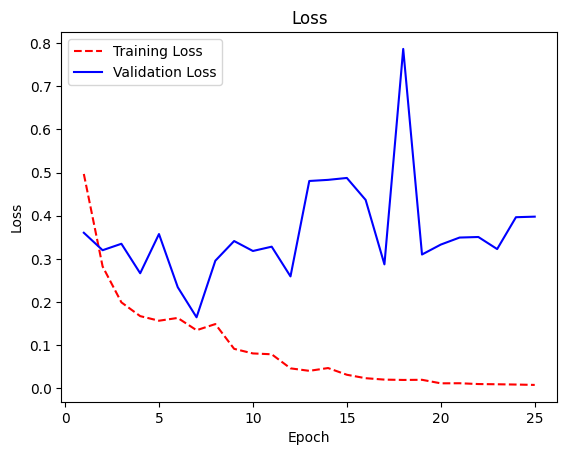

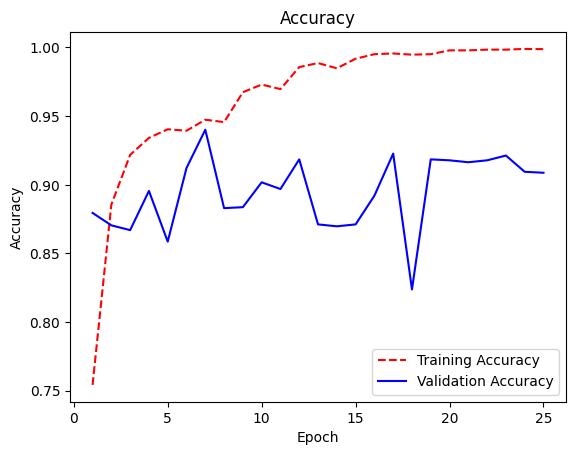

Epoch: 7
loss:0.13
accuracy:0.95
val_loss:0.16
val_accuracy:0.94
lr:0.0
__________ VGG_16_freeze __________________________________________________
Epoch 1/25
90/90 [==============================] - 8s 77ms/step - loss: 0.6605 - accuracy: 0.6195 - val_loss: 1.0573 - val_accuracy: 0.0850 - lr: 0.0010
Epoch 2/25
90/90 [==============================] - 5s 57ms/step - loss: 0.6117 - accuracy: 0.6764 - val_loss: 0.9158 - val_accuracy: 0.2221 - lr: 0.0010
Epoch 3/25
90/90 [==============================] - 5s 57ms/step - loss: 0.5854 - accuracy: 0.6992 - val_loss: 0.6481 - val_accuracy: 0.6149 - lr: 0.0010
Epoch 4/25
90/90 [==============================] - 5s 55ms/step - loss: 0.5767 - accuracy: 0.7050 - val_loss: 0.7463 - val_accuracy: 0.4993 - lr: 0.0010
Epoch 5/25
90/90 [==============================] - 5s 54ms/step - loss: 0.5553 - accuracy: 0.7245 - val_loss: 0.6562 - val_accuracy: 0.6253 - lr: 0.0010
Epoch 6/25
90/90 [==============================] - 5s 55ms/step - loss: 0.5531 - 

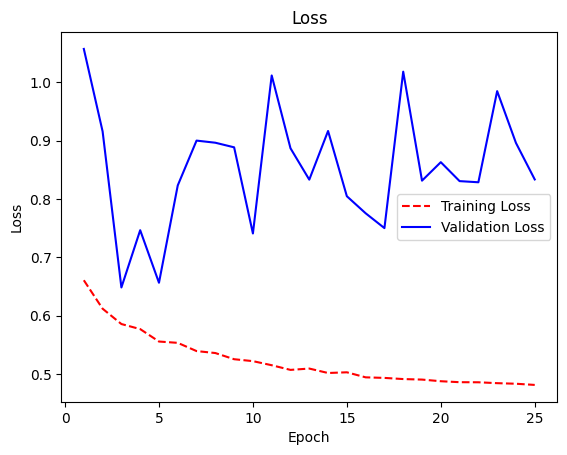

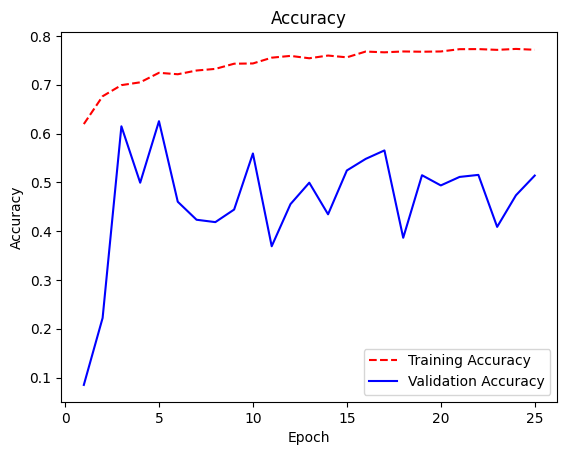

Epoch: 3
loss:0.59
accuracy:0.7
val_loss:0.65
val_accuracy:0.61
lr:0.0
__________ VGG_19_freeze __________________________________________________
Epoch 1/25
90/90 [==============================] - 9s 85ms/step - loss: 0.6515 - accuracy: 0.6238 - val_loss: 0.9779 - val_accuracy: 0.1546 - lr: 0.0010
Epoch 2/25
90/90 [==============================] - 6s 64ms/step - loss: 0.6031 - accuracy: 0.6721 - val_loss: 0.8956 - val_accuracy: 0.2939 - lr: 0.0010
Epoch 3/25
90/90 [==============================] - 6s 65ms/step - loss: 0.5758 - accuracy: 0.7006 - val_loss: 0.5837 - val_accuracy: 0.6971 - lr: 0.0010
Epoch 4/25
90/90 [==============================] - 6s 62ms/step - loss: 0.5641 - accuracy: 0.7060 - val_loss: 0.8488 - val_accuracy: 0.4325 - lr: 0.0010
Epoch 5/25
90/90 [==============================] - 6s 62ms/step - loss: 0.5532 - accuracy: 0.7200 - val_loss: 0.7420 - val_accuracy: 0.5432 - lr: 0.0010
Epoch 6/25
90/90 [==============================] - 6s 62ms/step - loss: 0.5428 - a

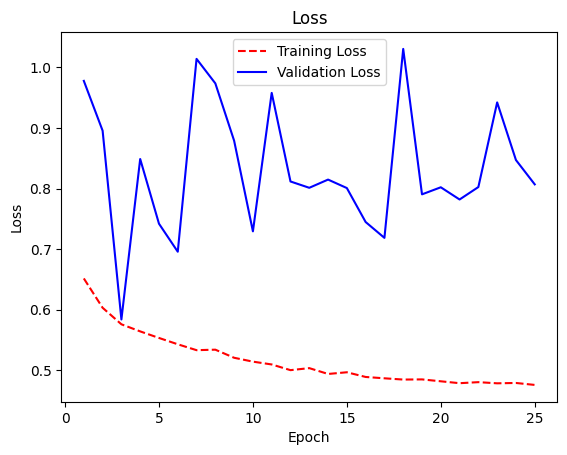

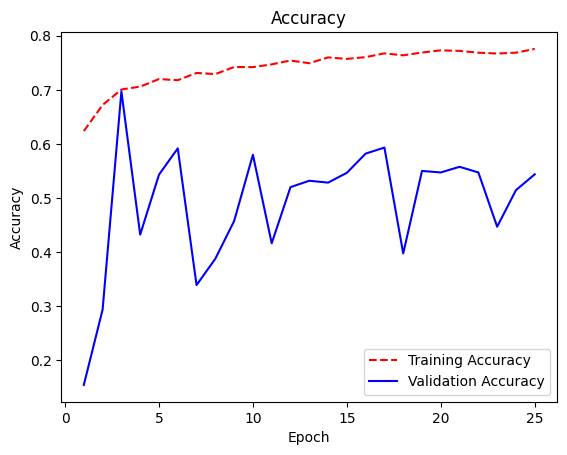

Epoch: 3
loss:0.58
accuracy:0.7
val_loss:0.58
val_accuracy:0.7
lr:0.0


In [13]:
for key in model_softmax.keys():
  print("_"*10, key, "_"*50)
  model_softmax[key] = Model(model_softmax[key], 0.001, f'/content/drive/MyDrive/final_model/checkpoint/{key}', "categorical_crossentropy")
  model_softmax[key].train(model_data[key].images, model_data[key].labels, batch_size=64, epoch=25, validation_split=0.2)
  tf.keras.backend.clear_session()

In [14]:
# for key in model_softmax.keys():
#   model_softmax[key] = Model(model_softmax[key], 0.001, f'/content/drive/MyDrive/final_model/checkpoint/{key}', "categorical_crossentropy")

## Elm Training

In [15]:
for key in model_softmax.keys():
  for layer in model_softmax[key].model.layers:
      layer.trainable = False
  model_softmax[key].remove_layer(2)

In [16]:
def batch_predict(model, images, batch=32):
  array1 = []
  for idx in range(0, len(images), batch):
    array2 = model.predict(images[idx: min(len(images), idx+batch)], verbose=0)
    if len(array1)>0:
      array1 = np.concatenate((array1, array2), axis=0)
    else:
      array1 = array2
  return array1

In [17]:
model_elm = {}
for key in model_softmax.keys():
  print("_"*10, key, "_"*10)
  Xtrain = batch_predict(model_softmax[key].headless_model, model_data[key].images, 64)
  Ytrain = model_data[key].labels[...,0] == 0

  model_elm[key] = elm(hidden_units=16, activation_function='relu', random_type='normal', x=Xtrain, y=Ytrain, C=0.1, elm_type='clf')
  beta, train_accuracy, running_time = model_elm[key].fit('solution2')
  print("classifier train accuracy:", train_accuracy)
  print('classifier running time:', running_time)

__________ Resnet_152_full __________
classifier train accuracy: 0.908888269713012
classifier running time: 0.027801036834716797
__________ Resnet_101_full __________
classifier train accuracy: 0.6283087210922262
classifier running time: 0.015269279479980469
__________ Resnet_50_full __________
classifier train accuracy: 0.583728057954862
classifier running time: 0.019399404525756836
__________ Resnet_152_freeze __________
classifier train accuracy: 0.828364446921148
classifier running time: 0.015341520309448242
__________ Resnet_101_freeze __________
classifier train accuracy: 0.5958484257453329
classifier running time: 0.015039682388305664
__________ Resnet_50_freeze __________
classifier train accuracy: 0.5757871273335191
classifier running time: 0.015027284622192383
__________ VGG_16_full __________
classifier train accuracy: 0.9400947339091669
classifier running time: 0.019481658935546875
__________ VGG_19_full __________
classifier train accuracy: 0.9654499860685428
classifier ru

## Svm Training

In [18]:
model_svm = {}
for key in model_softmax.keys():
  print("_"*10, key, "_"*10)
  Xtrain = batch_predict(model_softmax[key].headless_model, model_data[key].images, 64)
  Ytrain = model_data[key].labels[...,0] == 0
  model_svm[key] = make_pipeline(SVC())
  model_svm[key].fit(Xtrain, Ytrain)
  print("Classifier train accuracy:", model_svm[key].score(Xtrain, Ytrain))

__________ Resnet_152_full __________
Classifier train accuracy: 0.934800780161605
__________ Resnet_101_full __________
Classifier train accuracy: 0.6726107550849819
__________ Resnet_50_full __________
Classifier train accuracy: 0.6405684034550014
__________ Resnet_152_freeze __________
Classifier train accuracy: 0.9081916968514907
__________ Resnet_101_freeze __________
Classifier train accuracy: 0.644051267762608
__________ Resnet_50_freeze __________
Classifier train accuracy: 0.6444692114795207
__________ VGG_16_full __________
Classifier train accuracy: 0.960852605182502
__________ VGG_19_full __________
Classifier train accuracy: 0.9648927277793257
__________ VGG_16_freeze __________
Classifier train accuracy: 0.716634159933129
__________ VGG_19_freeze __________
Classifier train accuracy: 0.7187238785176929


In [19]:
#dump training data
training_dataset = None
training_dataset_152_layer = None
model_data = None

## Load Test Data

In [20]:
# test Data
image_loc_ground = glob.glob(test_gt+"/*.jpg")
label_ground = len(image_loc_ground) * ["ground"]

image_loc_gen = glob.glob(test_gen+"/*.jpg")
label_gen = len(image_loc_gen) * ["recon"]

image_loc_ec = glob.glob(test_ec+"/*.jpg")
label_ec = len(image_loc_ec) * ["recon"]

image_loc_vqvae = glob.glob(test_vqvae+"/*.jpg")
label_vqvae = len(image_loc_vqvae) * ["recon"]

test_dataset = {
    "gen": DatasetCreation(
        image_loc_ground+image_loc_gen,
        label_ground+label_gen,
        "binary"
        ),
    "ec": DatasetCreation(
        image_loc_ground+image_loc_ec,
        label_ground+label_ec,
        "binary"
        ),
    "vqvae": DatasetCreation(
        image_loc_ground+image_loc_vqvae,
        label_ground+label_vqvae,
        "binary"
        ),
}

test_dataset_152_layer = {
    "gen": DatasetCreation(
        image_loc_ground+image_loc_gen,
        label_ground+label_gen,
        "binary",
        tf.keras.applications.resnet50.preprocess_input
        ),
    "ec": DatasetCreation(
        image_loc_ground+image_loc_ec,
        label_ground+label_ec,
        "binary",
        tf.keras.applications.resnet50.preprocess_input
        ),
    "vqvae": DatasetCreation(
        image_loc_ground+image_loc_vqvae,
        label_ground+label_vqvae,
        "binary",
        tf.keras.applications.resnet50.preprocess_input
        ),
}
model_data = {
    "Resnet_152_full": test_dataset_152_layer,
    "Resnet_101_full": test_dataset,
    "Resnet_50_full": test_dataset,
    "Resnet_152_freeze": test_dataset_152_layer,
    "Resnet_101_freeze": test_dataset,
    "Resnet_50_freeze": test_dataset,
    "VGG_16_full": test_dataset,
    "VGG_19_full": test_dataset,
    "VGG_16_freeze": test_dataset,
    "VGG_19_freeze": test_dataset,
}

_________Loading Images__________


100%|██████████| 1000/1000 [00:04<00:00, 211.95it/s]


_________Loading Images__________


100%|██████████| 1000/1000 [00:04<00:00, 229.43it/s]


_________Loading Images__________


100%|██████████| 1000/1000 [00:04<00:00, 219.06it/s]


_________Loading Images__________


100%|██████████| 1000/1000 [00:03<00:00, 307.50it/s]


_________Loading Images__________


100%|██████████| 1000/1000 [00:03<00:00, 321.45it/s]


_________Loading Images__________


100%|██████████| 1000/1000 [00:03<00:00, 297.31it/s]


## Testing

In [21]:
for model_name in model_softmax.keys():
  print("_"*10, model_name, "_"*10)

  for key in model_data[model_name].keys():
    y_result = batch_predict(model_softmax[model_name].model, model_data[model_name][key].images, 64)
    y_result = y_result[... ,0] < 0.5

    labels = model_data[model_name][key].labels
    print(f"{'_'*10}{key}{'_'*10}")
    print("Accuracy", accuracy_score(y_result, labels))

    # precision tp / (tp + fp)
    precision = precision_score(y_result, labels)
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(y_result, labels)
    print('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_result, labels)
    print('F1 score: %f' % f1)

__________ Resnet_152_full __________
__________gen__________
Accuracy 0.799
Precision: 0.824000
Recall: 0.784762
F1 score: 0.803902
__________ec__________
Accuracy 0.885
Precision: 0.996000
Recall: 0.815057
F1 score: 0.896490
__________vqvae__________
Accuracy 0.871
Precision: 0.968000
Recall: 0.810720
F1 score: 0.882407
__________ Resnet_101_full __________
__________gen__________
Accuracy 0.554
Precision: 0.546000
Recall: 0.554878
F1 score: 0.550403
__________ec__________
Accuracy 0.671
Precision: 0.780000
Recall: 0.640394
F1 score: 0.703336
__________vqvae__________
Accuracy 0.505
Precision: 0.448000
Recall: 0.505643
F1 score: 0.475080
__________ Resnet_50_full __________
__________gen__________
Accuracy 0.563
Precision: 0.642000
Recall: 0.554404
F1 score: 0.594995
__________ec__________
Accuracy 0.648
Precision: 0.812000
Recall: 0.611446
F1 score: 0.697595
__________vqvae__________
Accuracy 0.558
Precision: 0.632000
Recall: 0.550523
F1 score: 0.588454
__________ Resnet_152_freeze 

## Testing ELM

__________ Resnet_152_full __________
__________gen__________
Accuracy 0.78
Precision: 0.782000
Recall: 0.778884
F1 score: 0.780439


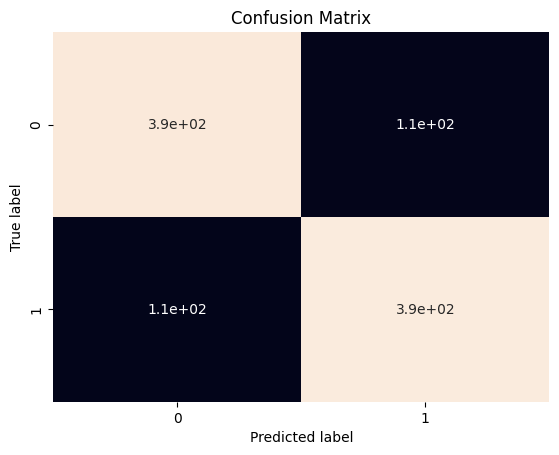

              precision    recall  f1-score   support

           0       0.78      0.78      0.78       500
           1       0.78      0.78      0.78       500

    accuracy                           0.78      1000
   macro avg       0.78      0.78      0.78      1000
weighted avg       0.78      0.78      0.78      1000

__________ec__________
Accuracy 0.883
Precision: 0.988000
Recall: 0.816529
F1 score: 0.894118


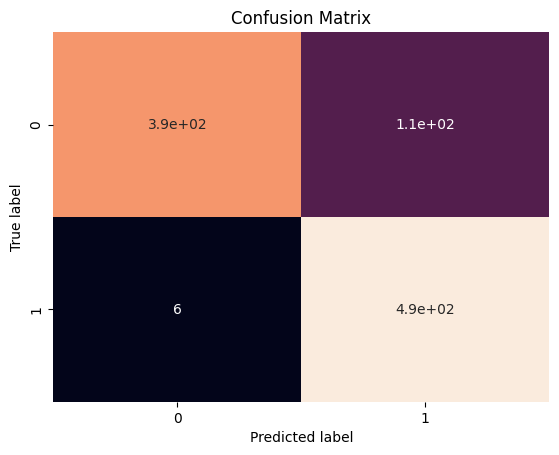

              precision    recall  f1-score   support

           0       0.98      0.78      0.87       500
           1       0.82      0.99      0.89       500

    accuracy                           0.88      1000
   macro avg       0.90      0.88      0.88      1000
weighted avg       0.90      0.88      0.88      1000

__________vqvae__________
Accuracy 0.868
Precision: 0.958000
Recall: 0.811864
F1 score: 0.878899


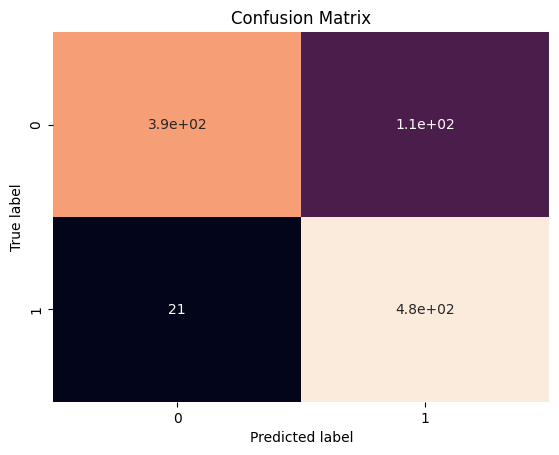

              precision    recall  f1-score   support

           0       0.95      0.78      0.85       500
           1       0.81      0.96      0.88       500

    accuracy                           0.87      1000
   macro avg       0.88      0.87      0.87      1000
weighted avg       0.88      0.87      0.87      1000

__________ Resnet_101_full __________
__________gen__________
Accuracy 0.542
Precision: 0.584000
Recall: 0.538745
F1 score: 0.560461


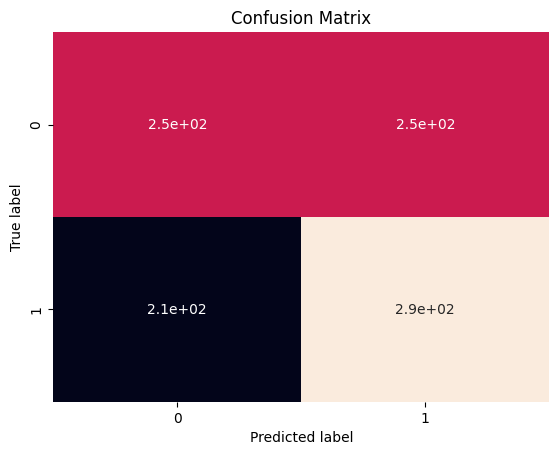

              precision    recall  f1-score   support

           0       0.55      0.50      0.52       500
           1       0.54      0.58      0.56       500

    accuracy                           0.54      1000
   macro avg       0.54      0.54      0.54      1000
weighted avg       0.54      0.54      0.54      1000

__________ec__________
Accuracy 0.667
Precision: 0.834000
Recall: 0.625187
F1 score: 0.714653


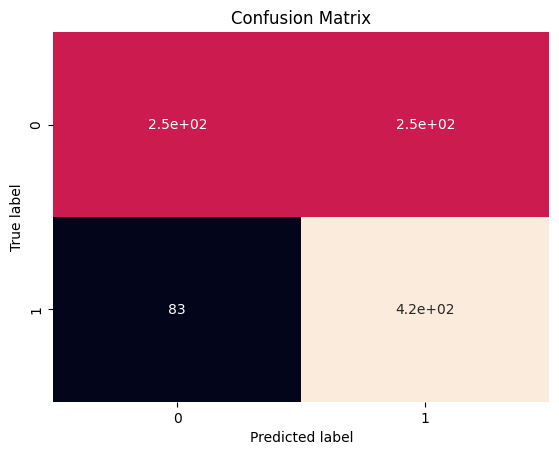

              precision    recall  f1-score   support

           0       0.75      0.50      0.60       500
           1       0.63      0.83      0.71       500

    accuracy                           0.67      1000
   macro avg       0.69      0.67      0.66      1000
weighted avg       0.69      0.67      0.66      1000

__________vqvae__________
Accuracy 0.484
Precision: 0.468000
Recall: 0.483471
F1 score: 0.475610


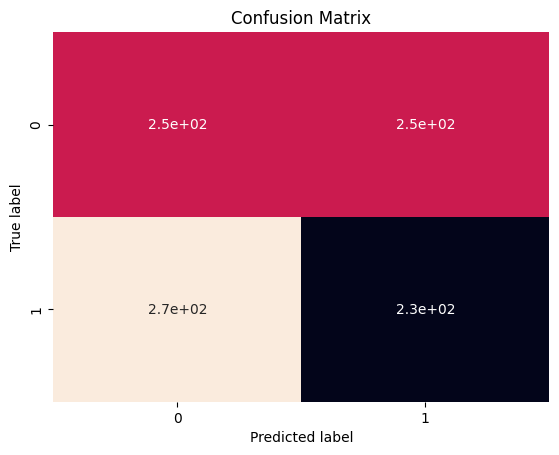

              precision    recall  f1-score   support

           0       0.48      0.50      0.49       500
           1       0.48      0.47      0.48       500

    accuracy                           0.48      1000
   macro avg       0.48      0.48      0.48      1000
weighted avg       0.48      0.48      0.48      1000

__________ Resnet_50_full __________
__________gen__________
Accuracy 0.537
Precision: 0.410000
Recall: 0.549598
F1 score: 0.469645


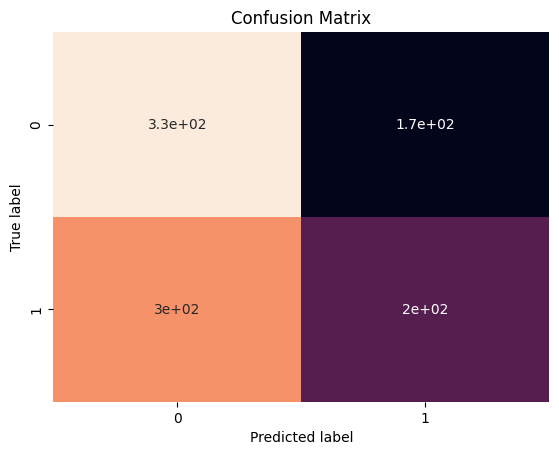

              precision    recall  f1-score   support

           0       0.53      0.66      0.59       500
           1       0.55      0.41      0.47       500

    accuracy                           0.54      1000
   macro avg       0.54      0.54      0.53      1000
weighted avg       0.54      0.54      0.53      1000

__________ec__________
Accuracy 0.629
Precision: 0.594000
Recall: 0.638710
F1 score: 0.615544


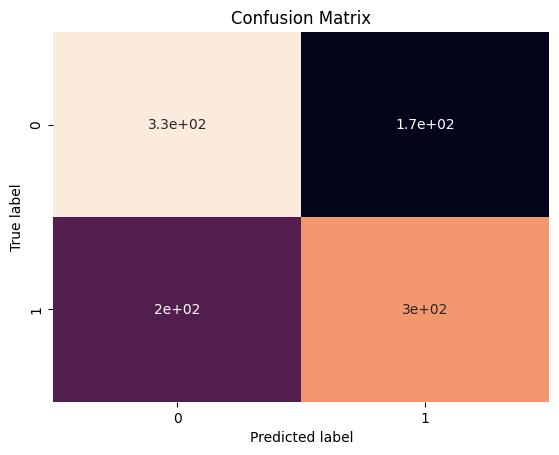

              precision    recall  f1-score   support

           0       0.62      0.66      0.64       500
           1       0.64      0.59      0.62       500

    accuracy                           0.63      1000
   macro avg       0.63      0.63      0.63      1000
weighted avg       0.63      0.63      0.63      1000

__________vqvae__________
Accuracy 0.554
Precision: 0.444000
Recall: 0.569231
F1 score: 0.498876


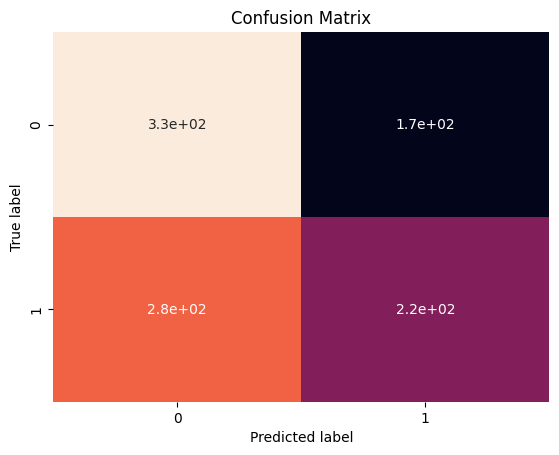

              precision    recall  f1-score   support

           0       0.54      0.66      0.60       500
           1       0.57      0.44      0.50       500

    accuracy                           0.55      1000
   macro avg       0.56      0.55      0.55      1000
weighted avg       0.56      0.55      0.55      1000

__________ Resnet_152_freeze __________
__________gen__________
Accuracy 0.729
Precision: 0.678000
Recall: 0.755011
F1 score: 0.714436


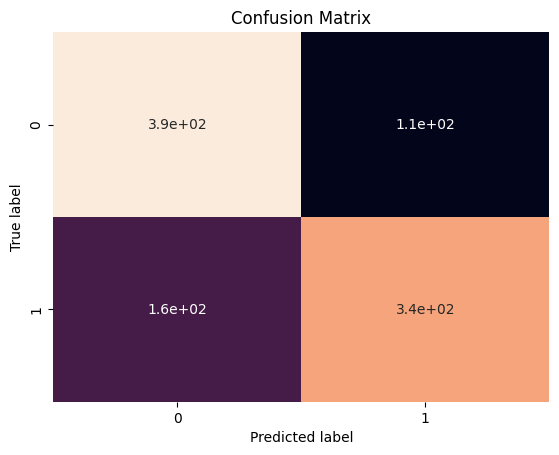

              precision    recall  f1-score   support

           0       0.71      0.78      0.74       500
           1       0.76      0.68      0.71       500

    accuracy                           0.73      1000
   macro avg       0.73      0.73      0.73      1000
weighted avg       0.73      0.73      0.73      1000

__________ec__________
Accuracy 0.865
Precision: 0.950000
Recall: 0.811966
F1 score: 0.875576


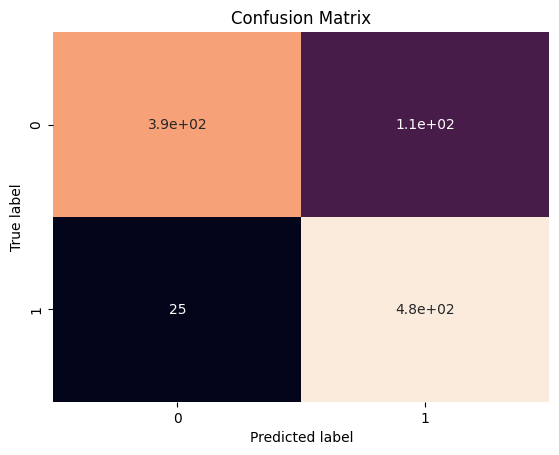

              precision    recall  f1-score   support

           0       0.94      0.78      0.85       500
           1       0.81      0.95      0.88       500

    accuracy                           0.86      1000
   macro avg       0.88      0.86      0.86      1000
weighted avg       0.88      0.86      0.86      1000

__________vqvae__________
Accuracy 0.839
Precision: 0.898000
Recall: 0.803220
F1 score: 0.847970


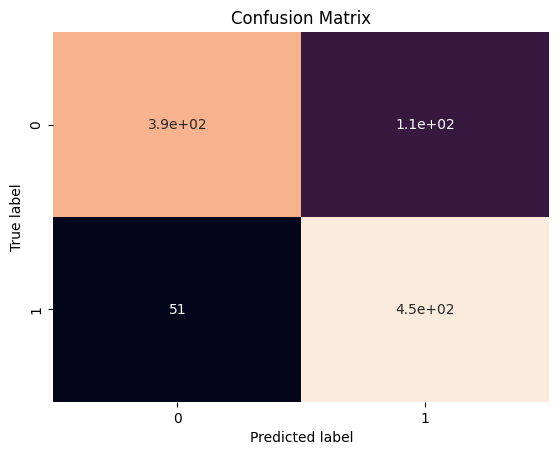

              precision    recall  f1-score   support

           0       0.88      0.78      0.83       500
           1       0.80      0.90      0.85       500

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000

__________ Resnet_101_freeze __________
__________gen__________
Accuracy 0.556
Precision: 0.498000
Recall: 0.563348
F1 score: 0.528662


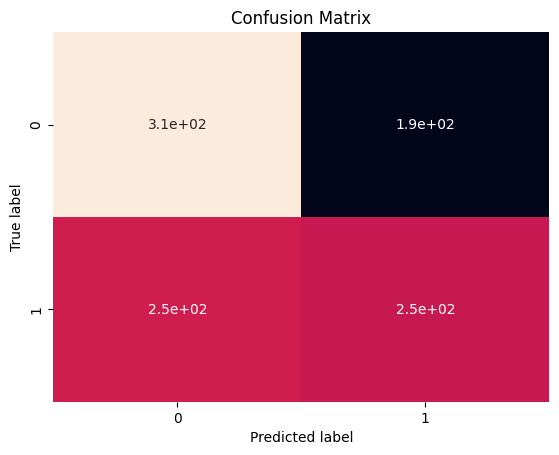

              precision    recall  f1-score   support

           0       0.55      0.61      0.58       500
           1       0.56      0.50      0.53       500

    accuracy                           0.56      1000
   macro avg       0.56      0.56      0.55      1000
weighted avg       0.56      0.56      0.55      1000

__________ec__________
Accuracy 0.645
Precision: 0.676000
Recall: 0.636535
F1 score: 0.655674


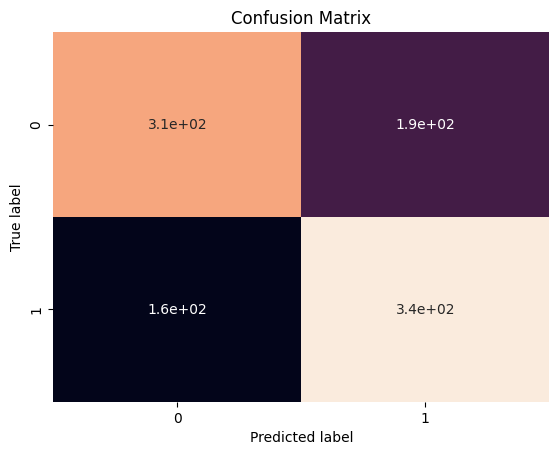

              precision    recall  f1-score   support

           0       0.65      0.61      0.63       500
           1       0.64      0.68      0.66       500

    accuracy                           0.65      1000
   macro avg       0.65      0.65      0.64      1000
weighted avg       0.65      0.65      0.64      1000

__________vqvae__________
Accuracy 0.52
Precision: 0.426000
Recall: 0.524631
F1 score: 0.470199


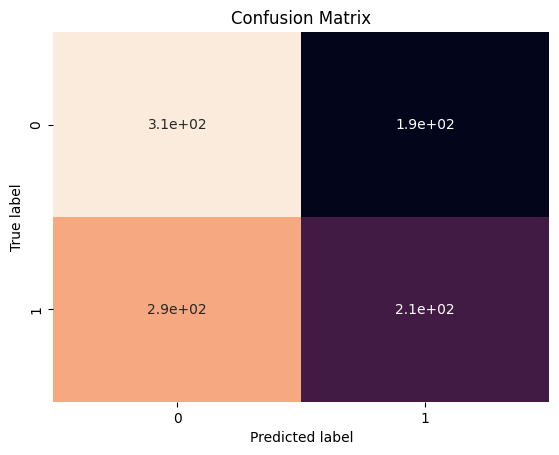

              precision    recall  f1-score   support

           0       0.52      0.61      0.56       500
           1       0.52      0.43      0.47       500

    accuracy                           0.52      1000
   macro avg       0.52      0.52      0.52      1000
weighted avg       0.52      0.52      0.52      1000

__________ Resnet_50_freeze __________
__________gen__________
Accuracy 0.554
Precision: 0.550000
Recall: 0.554435
F1 score: 0.552209


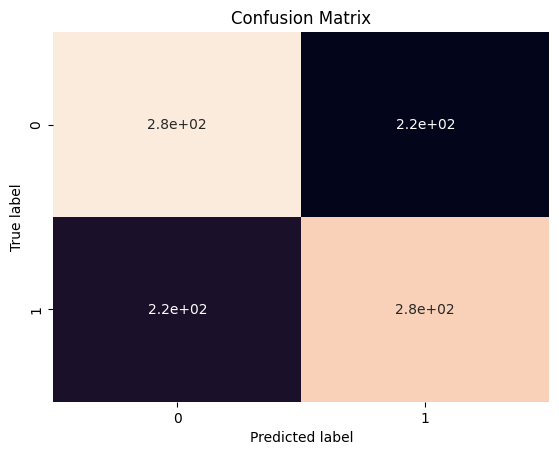

              precision    recall  f1-score   support

           0       0.55      0.56      0.56       500
           1       0.55      0.55      0.55       500

    accuracy                           0.55      1000
   macro avg       0.55      0.55      0.55      1000
weighted avg       0.55      0.55      0.55      1000

__________ec__________
Accuracy 0.63
Precision: 0.702000
Recall: 0.613636
F1 score: 0.654851


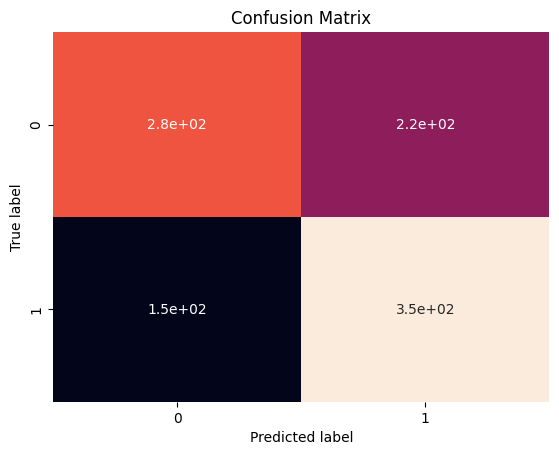

              precision    recall  f1-score   support

           0       0.65      0.56      0.60       500
           1       0.61      0.70      0.65       500

    accuracy                           0.63      1000
   macro avg       0.63      0.63      0.63      1000
weighted avg       0.63      0.63      0.63      1000

__________vqvae__________
Accuracy 0.534
Precision: 0.510000
Recall: 0.535714
F1 score: 0.522541


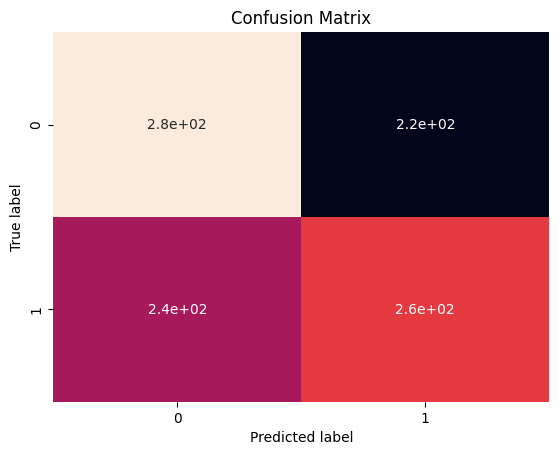

              precision    recall  f1-score   support

           0       0.53      0.56      0.54       500
           1       0.54      0.51      0.52       500

    accuracy                           0.53      1000
   macro avg       0.53      0.53      0.53      1000
weighted avg       0.53      0.53      0.53      1000

__________ VGG_16_full __________
__________gen__________
Accuracy 0.882
Precision: 0.894000
Recall: 0.873047
F1 score: 0.883399


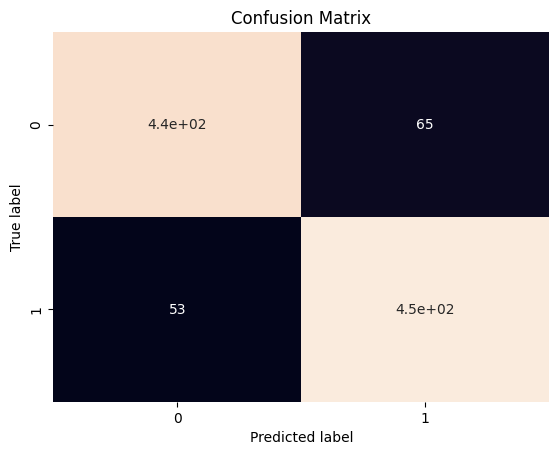

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       500
           1       0.87      0.89      0.88       500

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000

__________ec__________
Accuracy 0.934
Precision: 0.998000
Recall: 0.884752
F1 score: 0.937970


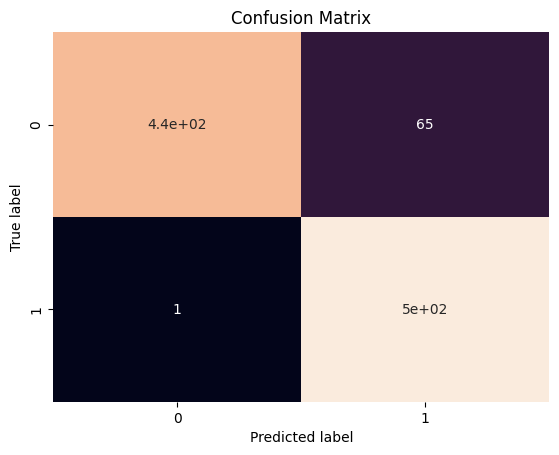

              precision    recall  f1-score   support

           0       1.00      0.87      0.93       500
           1       0.88      1.00      0.94       500

    accuracy                           0.93      1000
   macro avg       0.94      0.93      0.93      1000
weighted avg       0.94      0.93      0.93      1000

__________vqvae__________
Accuracy 0.927
Precision: 0.984000
Recall: 0.883303
F1 score: 0.930937


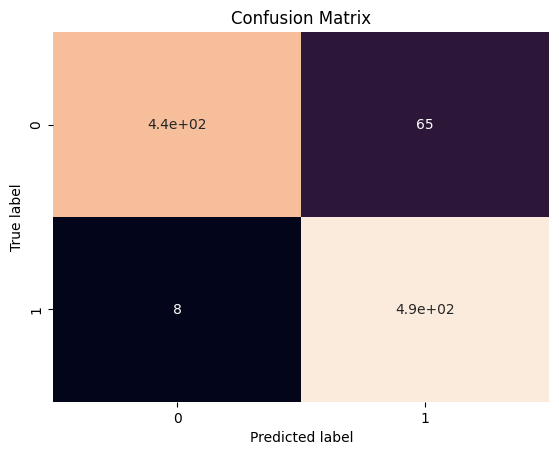

              precision    recall  f1-score   support

           0       0.98      0.87      0.92       500
           1       0.88      0.98      0.93       500

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000

__________ VGG_19_full __________
__________gen__________
Accuracy 0.902
Precision: 0.872000
Recall: 0.927660
F1 score: 0.898969


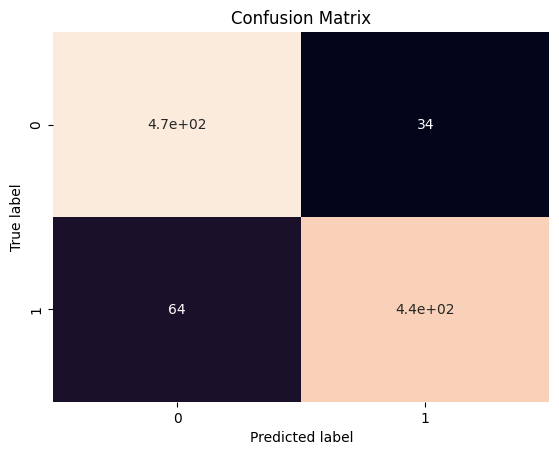

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       500
           1       0.93      0.87      0.90       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000

__________ec__________
Accuracy 0.964
Precision: 0.996000
Recall: 0.936090
F1 score: 0.965116


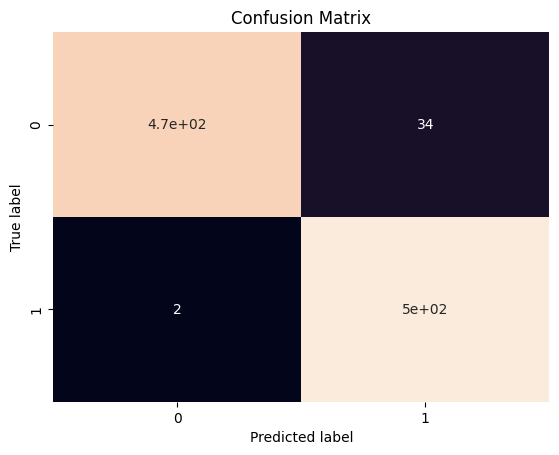

              precision    recall  f1-score   support

           0       1.00      0.93      0.96       500
           1       0.94      1.00      0.97       500

    accuracy                           0.96      1000
   macro avg       0.97      0.96      0.96      1000
weighted avg       0.97      0.96      0.96      1000

__________vqvae__________
Accuracy 0.947
Precision: 0.962000
Recall: 0.933981
F1 score: 0.947783


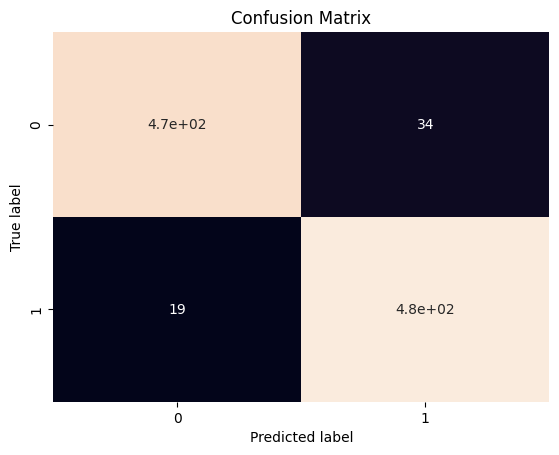

              precision    recall  f1-score   support

           0       0.96      0.93      0.95       500
           1       0.93      0.96      0.95       500

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000

__________ VGG_16_freeze __________
__________gen__________
Accuracy 0.568
Precision: 0.446000
Recall: 0.589947
F1 score: 0.507973


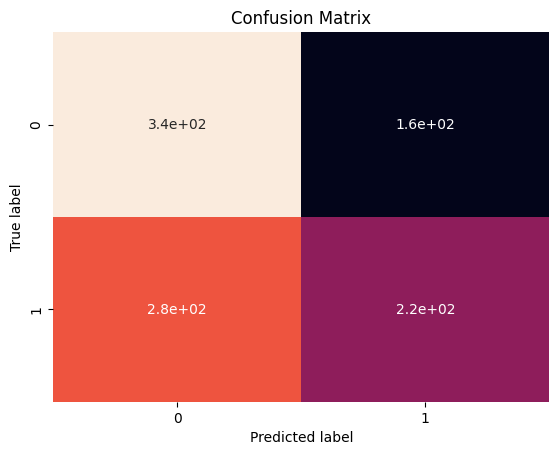

              precision    recall  f1-score   support

           0       0.55      0.69      0.61       500
           1       0.59      0.45      0.51       500

    accuracy                           0.57      1000
   macro avg       0.57      0.57      0.56      1000
weighted avg       0.57      0.57      0.56      1000

__________ec__________
Accuracy 0.673
Precision: 0.656000
Recall: 0.679089
F1 score: 0.667345


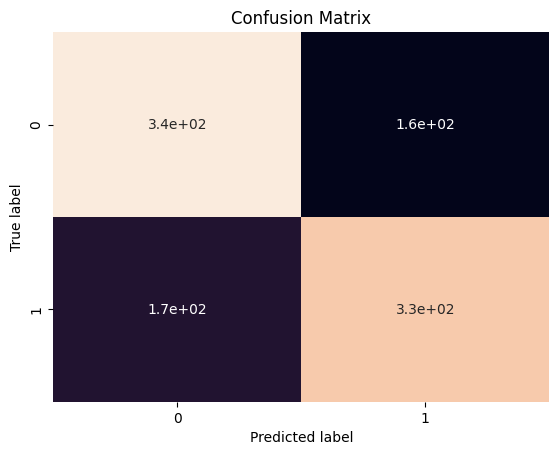

              precision    recall  f1-score   support

           0       0.67      0.69      0.68       500
           1       0.68      0.66      0.67       500

    accuracy                           0.67      1000
   macro avg       0.67      0.67      0.67      1000
weighted avg       0.67      0.67      0.67      1000

__________vqvae__________
Accuracy 0.689
Precision: 0.688000
Recall: 0.689379
F1 score: 0.688689


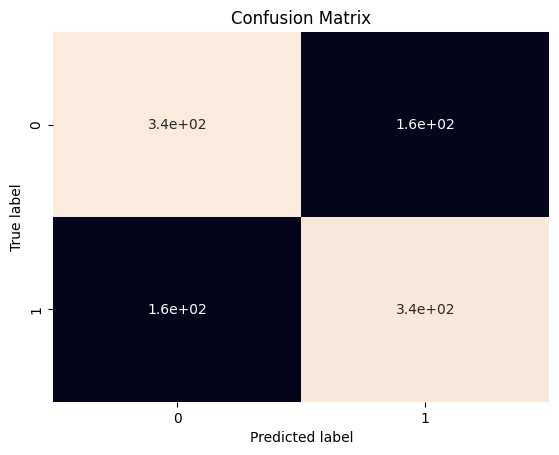

              precision    recall  f1-score   support

           0       0.69      0.69      0.69       500
           1       0.69      0.69      0.69       500

    accuracy                           0.69      1000
   macro avg       0.69      0.69      0.69      1000
weighted avg       0.69      0.69      0.69      1000

__________ VGG_19_freeze __________
__________gen__________
Accuracy 0.573
Precision: 0.442000
Recall: 0.598916
F1 score: 0.508631


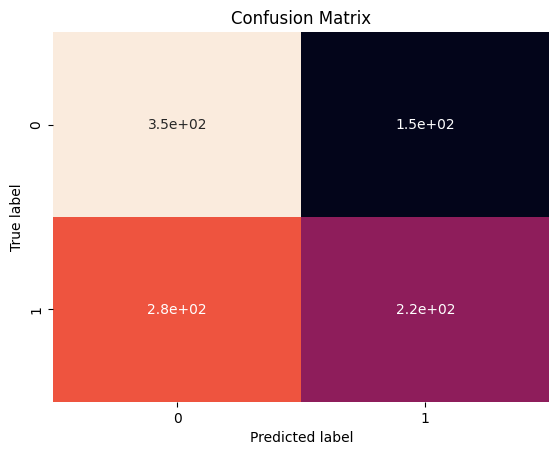

              precision    recall  f1-score   support

           0       0.56      0.70      0.62       500
           1       0.60      0.44      0.51       500

    accuracy                           0.57      1000
   macro avg       0.58      0.57      0.57      1000
weighted avg       0.58      0.57      0.57      1000

__________ec__________
Accuracy 0.693
Precision: 0.682000
Recall: 0.697342
F1 score: 0.689585


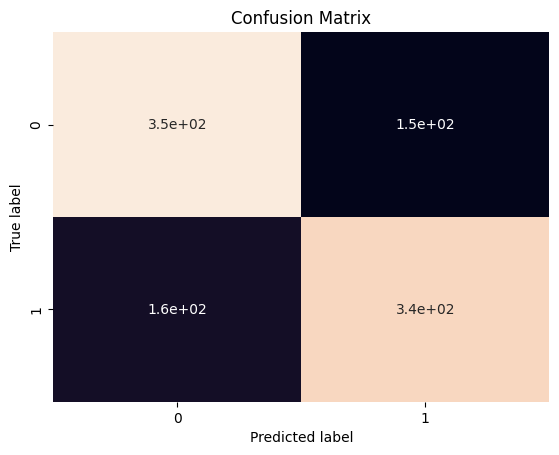

              precision    recall  f1-score   support

           0       0.69      0.70      0.70       500
           1       0.70      0.68      0.69       500

    accuracy                           0.69      1000
   macro avg       0.69      0.69      0.69      1000
weighted avg       0.69      0.69      0.69      1000

__________vqvae__________
Accuracy 0.722
Precision: 0.740000
Recall: 0.714286
F1 score: 0.726916


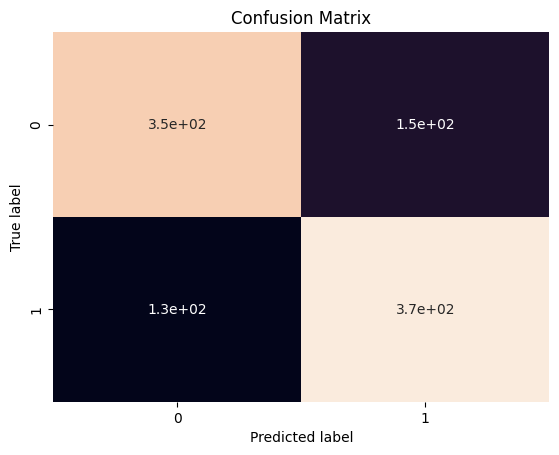

              precision    recall  f1-score   support

           0       0.73      0.70      0.72       500
           1       0.71      0.74      0.73       500

    accuracy                           0.72      1000
   macro avg       0.72      0.72      0.72      1000
weighted avg       0.72      0.72      0.72      1000



In [22]:
for model_name in model_softmax.keys():
  print("_"*10, model_name, "_"*10)

  for key in model_data[model_name].keys():
    Xtest = batch_predict(model_softmax[model_name].headless_model, model_data[model_name][key].images, 64)
    y_result = model_elm[model_name].predict(Xtest)

    labels = model_data[model_name][key].labels
    print(f"{'_'*10}{key}{'_'*10}")
    print("Accuracy", accuracy_score(y_result, labels))

    # precision tp / (tp + fp)
    precision = precision_score(y_result, labels)
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(y_result, labels)
    print('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_result, labels)
    print('F1 score: %f' % f1)

    cm8 = confusion_matrix(labels, y_result)
    sns.heatmap(cm8, annot=True, cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()
    print(classification_report(labels, y_result))

## Testing SVM

__________ Resnet_152_full __________
__________gen__________
Accuracy 0.795
Precision: 0.742000
Recall: 0.829978
F1 score: 0.783527


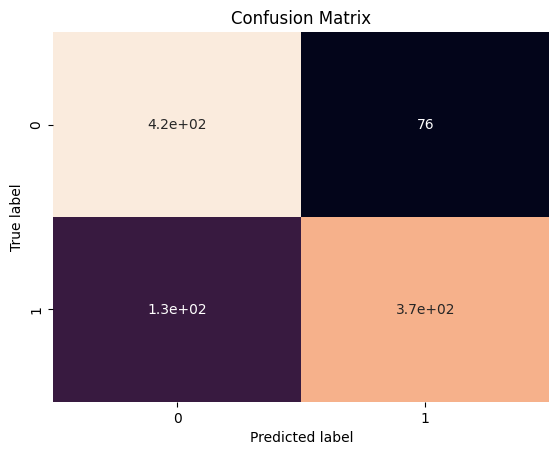

              precision    recall  f1-score   support

           0       0.77      0.85      0.81       500
           1       0.83      0.74      0.78       500

    accuracy                           0.80      1000
   macro avg       0.80      0.79      0.79      1000
weighted avg       0.80      0.80      0.79      1000

__________ec__________
Accuracy 0.917
Precision: 0.986000
Recall: 0.866432
F1 score: 0.922357


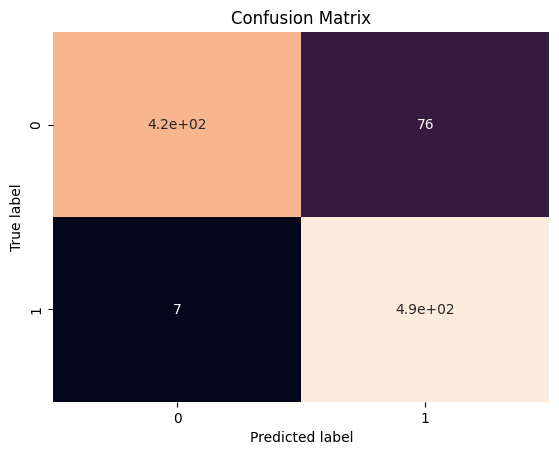

              precision    recall  f1-score   support

           0       0.98      0.85      0.91       500
           1       0.87      0.99      0.92       500

    accuracy                           0.92      1000
   macro avg       0.93      0.92      0.92      1000
weighted avg       0.93      0.92      0.92      1000

__________vqvae__________
Accuracy 0.903
Precision: 0.958000
Recall: 0.863063
F1 score: 0.908057


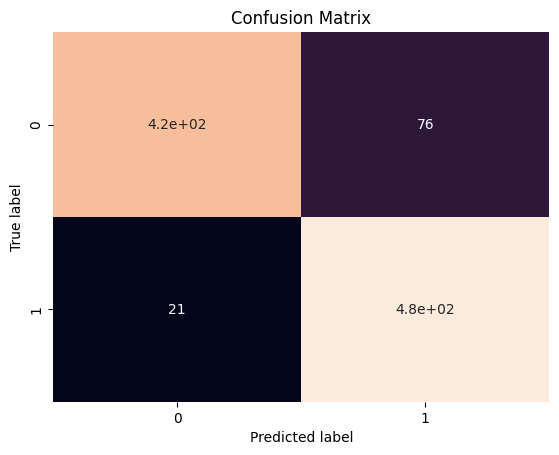

              precision    recall  f1-score   support

           0       0.95      0.85      0.90       500
           1       0.86      0.96      0.91       500

    accuracy                           0.90      1000
   macro avg       0.91      0.90      0.90      1000
weighted avg       0.91      0.90      0.90      1000

__________ Resnet_101_full __________
__________gen__________
Accuracy 0.574
Precision: 0.538000
Recall: 0.579741
F1 score: 0.558091


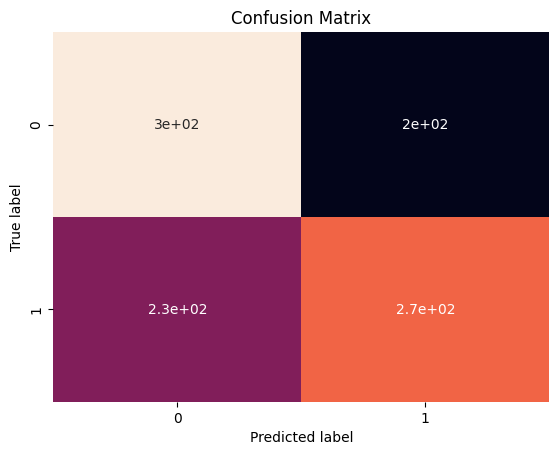

              precision    recall  f1-score   support

           0       0.57      0.61      0.59       500
           1       0.58      0.54      0.56       500

    accuracy                           0.57      1000
   macro avg       0.57      0.57      0.57      1000
weighted avg       0.57      0.57      0.57      1000

__________ec__________
Accuracy 0.722
Precision: 0.834000
Recall: 0.681373
F1 score: 0.750000


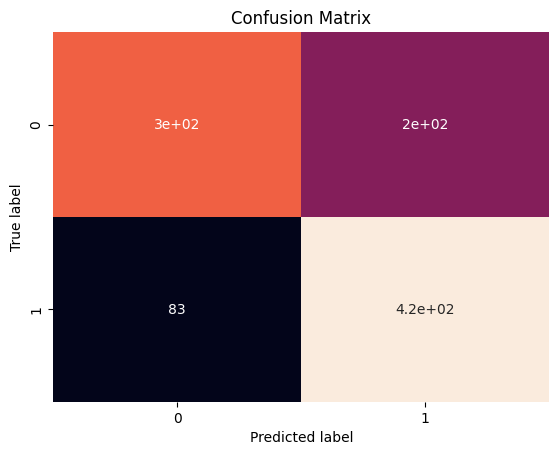

              precision    recall  f1-score   support

           0       0.79      0.61      0.69       500
           1       0.68      0.83      0.75       500

    accuracy                           0.72      1000
   macro avg       0.73      0.72      0.72      1000
weighted avg       0.73      0.72      0.72      1000

__________vqvae__________
Accuracy 0.524
Precision: 0.438000
Recall: 0.528986
F1 score: 0.479212


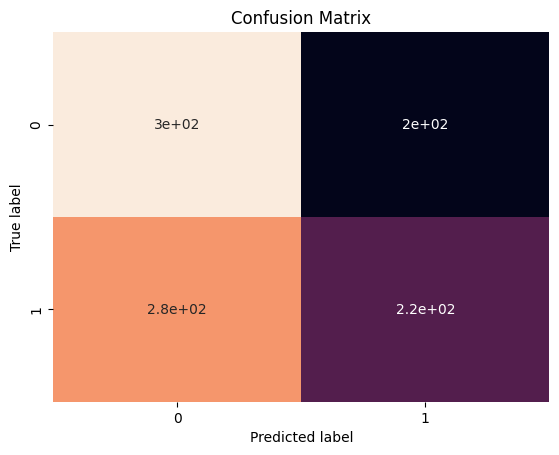

              precision    recall  f1-score   support

           0       0.52      0.61      0.56       500
           1       0.53      0.44      0.48       500

    accuracy                           0.52      1000
   macro avg       0.52      0.52      0.52      1000
weighted avg       0.52      0.52      0.52      1000

__________ Resnet_50_full __________
__________gen__________
Accuracy 0.585
Precision: 0.528000
Recall: 0.595937
F1 score: 0.559915


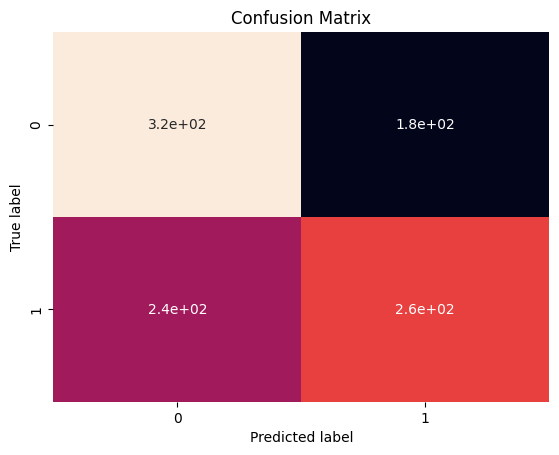

              precision    recall  f1-score   support

           0       0.58      0.64      0.61       500
           1       0.60      0.53      0.56       500

    accuracy                           0.58      1000
   macro avg       0.59      0.58      0.58      1000
weighted avg       0.59      0.58      0.58      1000

__________ec__________
Accuracy 0.724
Precision: 0.806000
Recall: 0.692440
F1 score: 0.744917


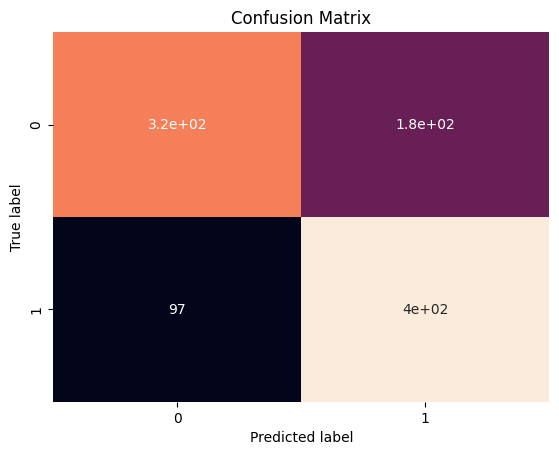

              precision    recall  f1-score   support

           0       0.77      0.64      0.70       500
           1       0.69      0.81      0.74       500

    accuracy                           0.72      1000
   macro avg       0.73      0.72      0.72      1000
weighted avg       0.73      0.72      0.72      1000

__________vqvae__________
Accuracy 0.568
Precision: 0.494000
Recall: 0.579812
F1 score: 0.533477


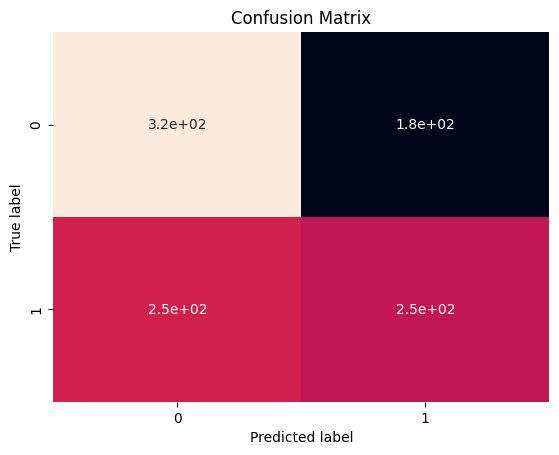

              precision    recall  f1-score   support

           0       0.56      0.64      0.60       500
           1       0.58      0.49      0.53       500

    accuracy                           0.57      1000
   macro avg       0.57      0.57      0.57      1000
weighted avg       0.57      0.57      0.57      1000

__________ Resnet_152_freeze __________
__________gen__________
Accuracy 0.77
Precision: 0.712000
Recall: 0.805430
F1 score: 0.755839


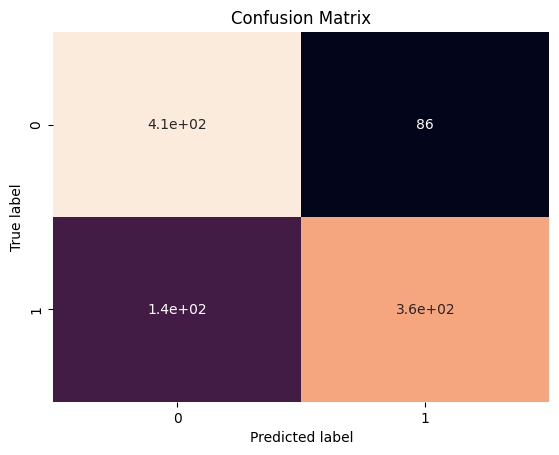

              precision    recall  f1-score   support

           0       0.74      0.83      0.78       500
           1       0.81      0.71      0.76       500

    accuracy                           0.77      1000
   macro avg       0.77      0.77      0.77      1000
weighted avg       0.77      0.77      0.77      1000

__________ec__________
Accuracy 0.909
Precision: 0.990000
Recall: 0.851979
F1 score: 0.915819


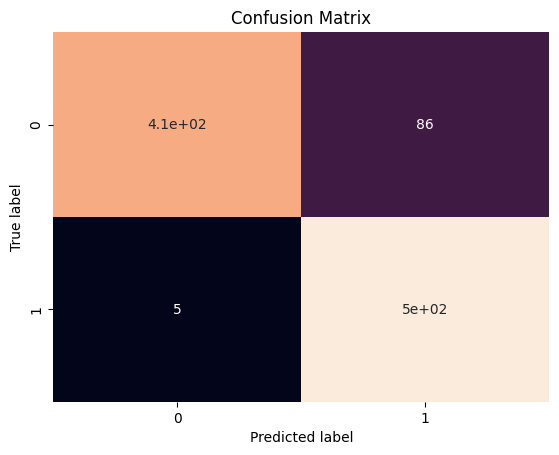

              precision    recall  f1-score   support

           0       0.99      0.83      0.90       500
           1       0.85      0.99      0.92       500

    accuracy                           0.91      1000
   macro avg       0.92      0.91      0.91      1000
weighted avg       0.92      0.91      0.91      1000

__________vqvae__________
Accuracy 0.889
Precision: 0.950000
Recall: 0.846702
F1 score: 0.895382


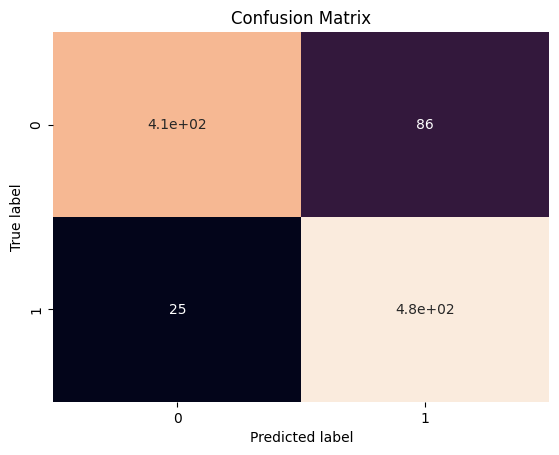

              precision    recall  f1-score   support

           0       0.94      0.83      0.88       500
           1       0.85      0.95      0.90       500

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000

__________ Resnet_101_freeze __________
__________gen__________
Accuracy 0.576
Precision: 0.572000
Recall: 0.576613
F1 score: 0.574297


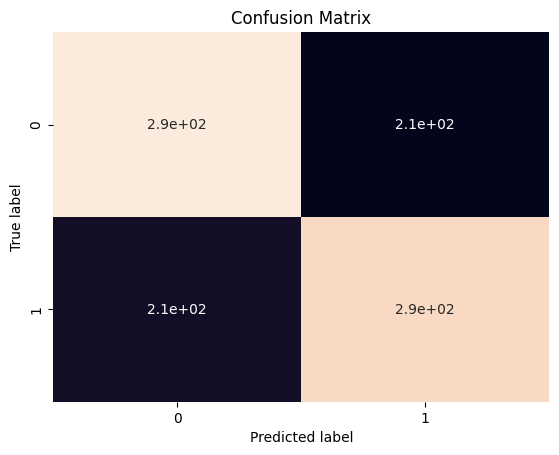

              precision    recall  f1-score   support

           0       0.58      0.58      0.58       500
           1       0.58      0.57      0.57       500

    accuracy                           0.58      1000
   macro avg       0.58      0.58      0.58      1000
weighted avg       0.58      0.58      0.58      1000

__________ec__________
Accuracy 0.694
Precision: 0.808000
Recall: 0.657980
F1 score: 0.725314


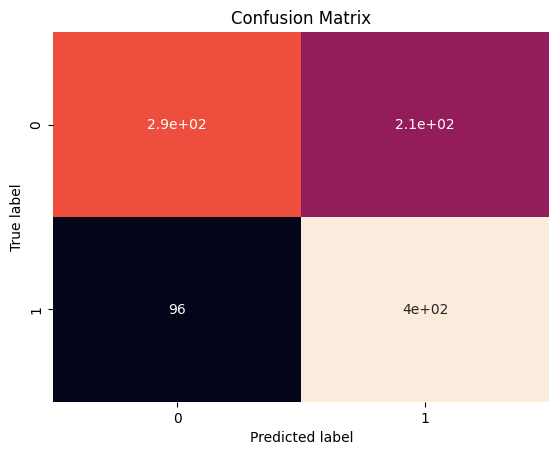

              precision    recall  f1-score   support

           0       0.75      0.58      0.65       500
           1       0.66      0.81      0.73       500

    accuracy                           0.69      1000
   macro avg       0.70      0.69      0.69      1000
weighted avg       0.70      0.69      0.69      1000

__________vqvae__________
Accuracy 0.541
Precision: 0.502000
Recall: 0.544469
F1 score: 0.522373


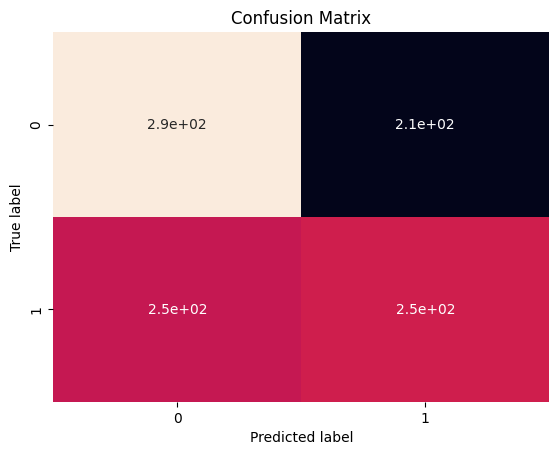

              precision    recall  f1-score   support

           0       0.54      0.58      0.56       500
           1       0.54      0.50      0.52       500

    accuracy                           0.54      1000
   macro avg       0.54      0.54      0.54      1000
weighted avg       0.54      0.54      0.54      1000

__________ Resnet_50_freeze __________
__________gen__________
Accuracy 0.591
Precision: 0.524000
Recall: 0.605081
F1 score: 0.561629


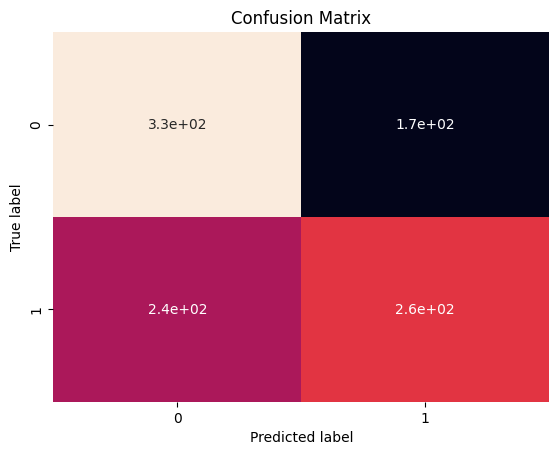

              precision    recall  f1-score   support

           0       0.58      0.66      0.62       500
           1       0.61      0.52      0.56       500

    accuracy                           0.59      1000
   macro avg       0.59      0.59      0.59      1000
weighted avg       0.59      0.59      0.59      1000

__________ec__________
Accuracy 0.729
Precision: 0.800000
Recall: 0.700525
F1 score: 0.746965


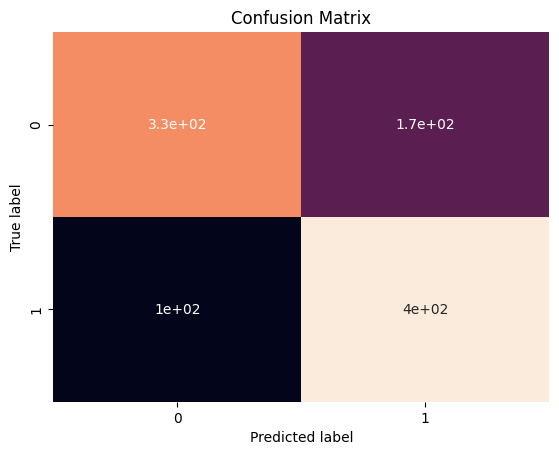

              precision    recall  f1-score   support

           0       0.77      0.66      0.71       500
           1       0.70      0.80      0.75       500

    accuracy                           0.73      1000
   macro avg       0.73      0.73      0.73      1000
weighted avg       0.73      0.73      0.73      1000

__________vqvae__________
Accuracy 0.569
Precision: 0.480000
Recall: 0.583942
F1 score: 0.526894


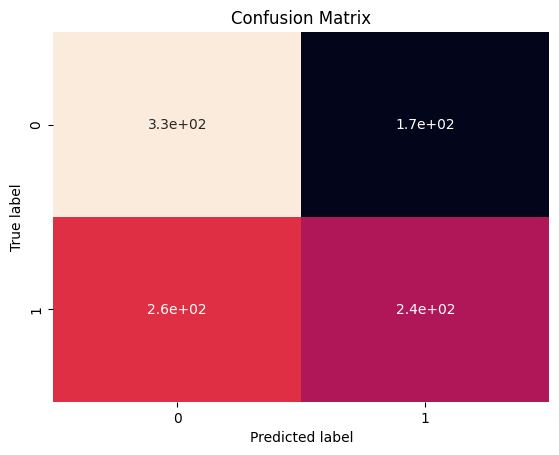

              precision    recall  f1-score   support

           0       0.56      0.66      0.60       500
           1       0.58      0.48      0.53       500

    accuracy                           0.57      1000
   macro avg       0.57      0.57      0.57      1000
weighted avg       0.57      0.57      0.57      1000

__________ VGG_16_full __________
__________gen__________
Accuracy 0.899
Precision: 0.874000
Recall: 0.920000
F1 score: 0.896410


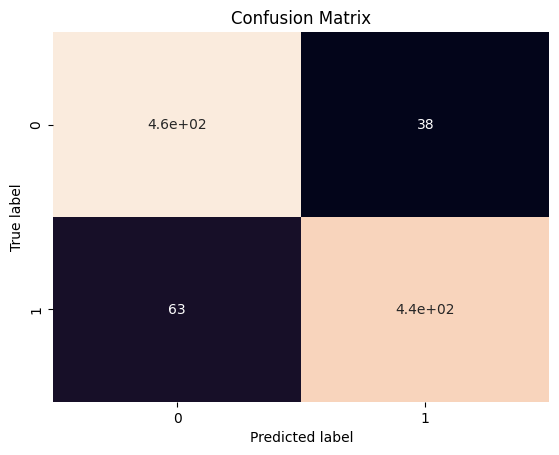

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       500
           1       0.92      0.87      0.90       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000

__________ec__________
Accuracy 0.958
Precision: 0.992000
Recall: 0.928839
F1 score: 0.959381


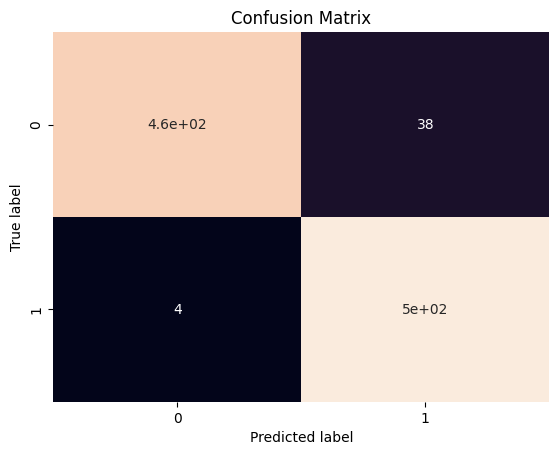

              precision    recall  f1-score   support

           0       0.99      0.92      0.96       500
           1       0.93      0.99      0.96       500

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000

__________vqvae__________
Accuracy 0.946
Precision: 0.968000
Recall: 0.927203
F1 score: 0.947162


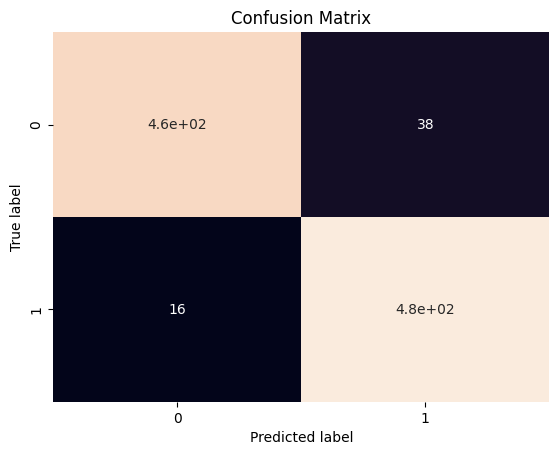

              precision    recall  f1-score   support

           0       0.97      0.92      0.94       500
           1       0.93      0.97      0.95       500

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000

__________ VGG_19_full __________
__________gen__________
Accuracy 0.898
Precision: 0.858000
Recall: 0.932609
F1 score: 0.893750


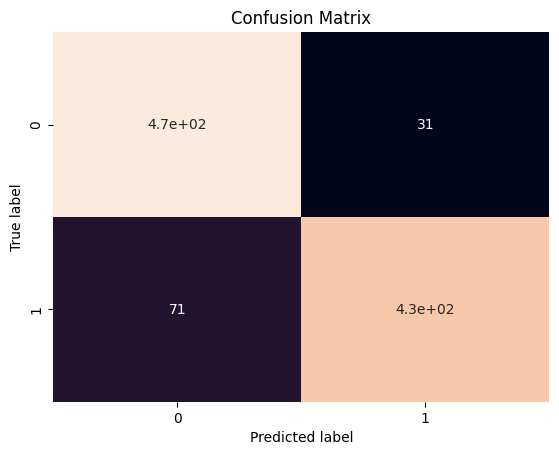

              precision    recall  f1-score   support

           0       0.87      0.94      0.90       500
           1       0.93      0.86      0.89       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000

__________ec__________
Accuracy 0.967
Precision: 0.996000
Recall: 0.941399
F1 score: 0.967930


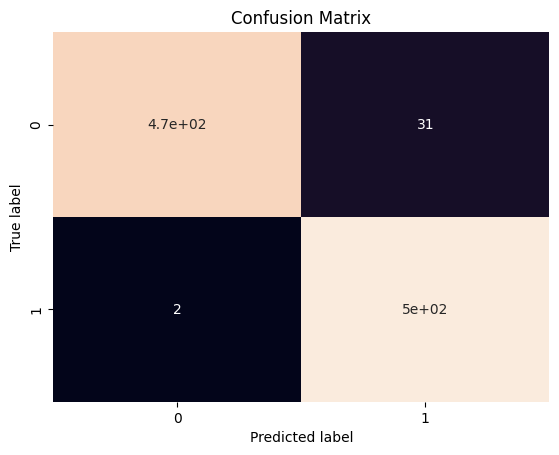

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       500
           1       0.94      1.00      0.97       500

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000

__________vqvae__________
Accuracy 0.95
Precision: 0.962000
Recall: 0.939453
F1 score: 0.950593


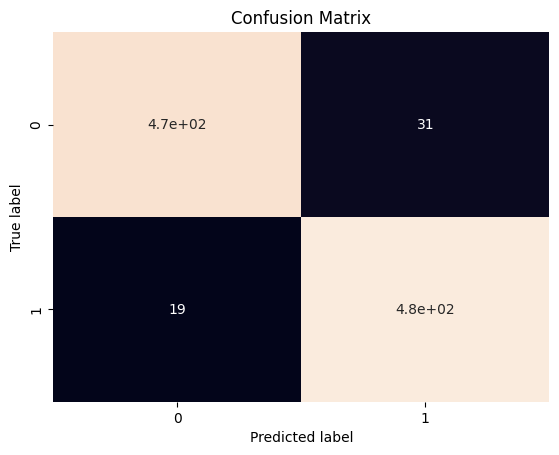

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       500
           1       0.94      0.96      0.95       500

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000

__________ VGG_16_freeze __________
__________gen__________
Accuracy 0.616
Precision: 0.516000
Recall: 0.645000
F1 score: 0.573333


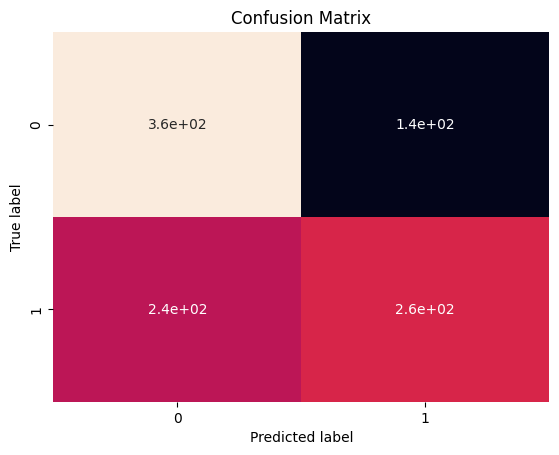

              precision    recall  f1-score   support

           0       0.60      0.72      0.65       500
           1       0.65      0.52      0.57       500

    accuracy                           0.62      1000
   macro avg       0.62      0.62      0.61      1000
weighted avg       0.62      0.62      0.61      1000

__________ec__________
Accuracy 0.77
Precision: 0.824000
Recall: 0.743682
F1 score: 0.781784


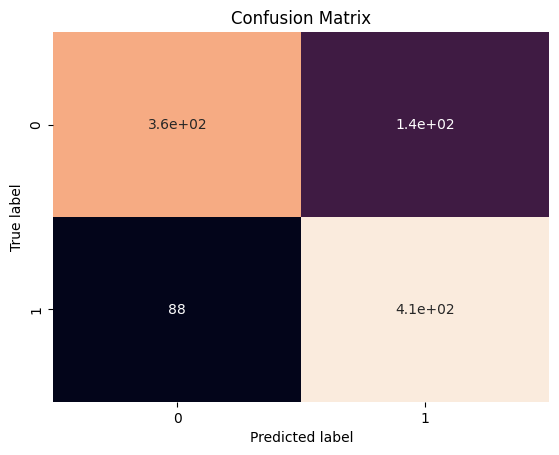

              precision    recall  f1-score   support

           0       0.80      0.72      0.76       500
           1       0.74      0.82      0.78       500

    accuracy                           0.77      1000
   macro avg       0.77      0.77      0.77      1000
weighted avg       0.77      0.77      0.77      1000

__________vqvae__________
Accuracy 0.771
Precision: 0.826000
Recall: 0.744144
F1 score: 0.782938


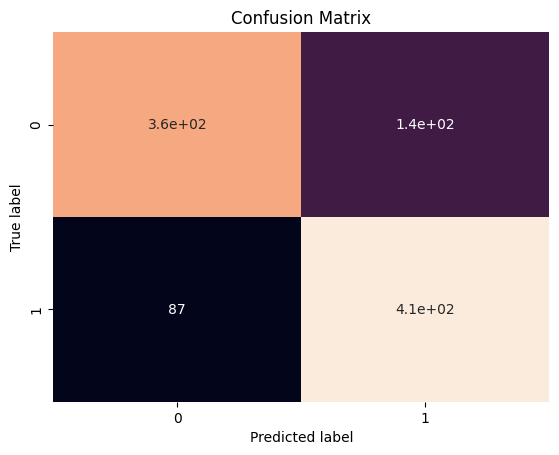

              precision    recall  f1-score   support

           0       0.80      0.72      0.76       500
           1       0.74      0.83      0.78       500

    accuracy                           0.77      1000
   macro avg       0.77      0.77      0.77      1000
weighted avg       0.77      0.77      0.77      1000

__________ VGG_19_freeze __________
__________gen__________
Accuracy 0.599
Precision: 0.510000
Recall: 0.620438
F1 score: 0.559824


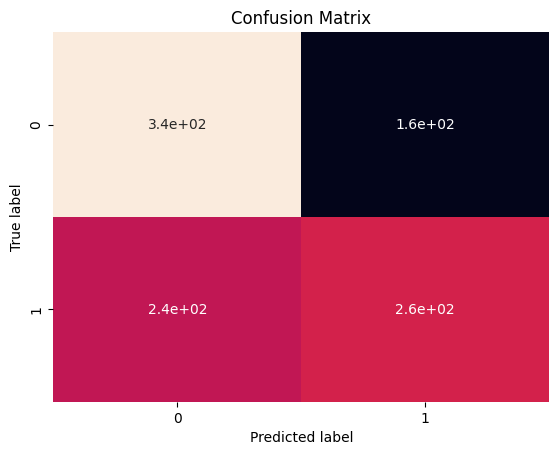

              precision    recall  f1-score   support

           0       0.58      0.69      0.63       500
           1       0.62      0.51      0.56       500

    accuracy                           0.60      1000
   macro avg       0.60      0.60      0.60      1000
weighted avg       0.60      0.60      0.60      1000

__________ec__________
Accuracy 0.757
Precision: 0.826000
Recall: 0.725835
F1 score: 0.772685


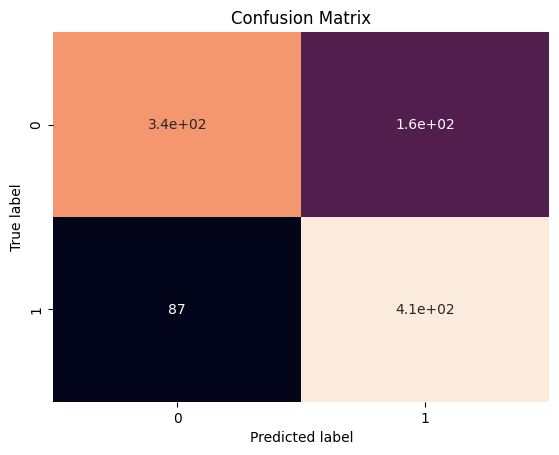

              precision    recall  f1-score   support

           0       0.80      0.69      0.74       500
           1       0.73      0.83      0.77       500

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.76      0.76      0.76      1000

__________vqvae__________
Accuracy 0.746
Precision: 0.804000
Recall: 0.720430
F1 score: 0.759924


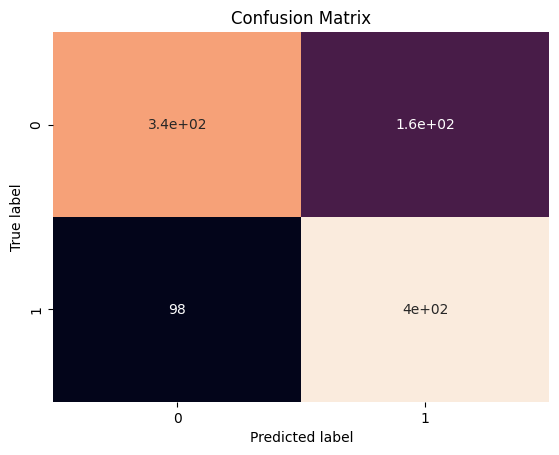

              precision    recall  f1-score   support

           0       0.78      0.69      0.73       500
           1       0.72      0.80      0.76       500

    accuracy                           0.75      1000
   macro avg       0.75      0.75      0.75      1000
weighted avg       0.75      0.75      0.75      1000



In [23]:
for model_name in model_softmax.keys():
  print("_"*10, model_name, "_"*10)

  for key in model_data[model_name].keys():
    Xtest = batch_predict(model_softmax[model_name].headless_model, model_data[model_name][key].images, 64)
    y_result = model_svm[model_name].predict(Xtest)

    labels = model_data[model_name][key].labels
    print(f"{'_'*10}{key}{'_'*10}")
    print("Accuracy", accuracy_score(y_result, labels))

    # precision tp / (tp + fp)
    precision = precision_score(y_result, labels)
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(y_result, labels)
    print('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_result, labels)
    print('F1 score: %f' % f1)

    cm8 = confusion_matrix(labels, y_result)
    sns.heatmap(cm8, annot=True, cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()
    print(classification_report(labels, y_result))